<a href="https://colab.research.google.com/github/Mengzhe/Project_Demos/blob/main/LendingClub2012_2020Q1_final_presentation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Lending Club 2007-2020Q3
Consolidated Data of All the years

Dataset: 
https://www.kaggle.com/ethon0426/lending-club-20072020q1

Objectives: 


1.   Build predictive models for default rate, e.g, boosting trees (XGBoost, Light GBM), neural network and generalized additive model (GAM).
2.   Explain models using Shapley values. 


Reference: 


1.   https://shap.readthedocs.io/en/latest/index.html
2.   https://christophm.github.io/interpretable-ml-book/shapley.html









## Download data and data description

#### Download data

In [ ]:
import os
os.environ['KAGGLE_CONFIG_DIR'] = '/content/drive/MyDrive/Colab Notebooks/Kaggle'

In [ ]:
!kaggle datasets download --force -d ethon0426/lending-club-20072020q1
!unzip -o *.zip

100% 480M/482M [00:03<00:00, 135MB/s]
100% 482M/482M [00:04<00:00, 126MB/s]
Archive:  lending-club-20072020q1.zip
  inflating: LCDataDictionary.xlsx   
  inflating: Loan_status_2007-2020Q3.gzip  


#### Import library and functions

In [ ]:
!pip install xgboost==1.4.2

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns

%matplotlib inline

import sklearn
from sklearn.preprocessing import MinMaxScaler, LabelEncoder
from sklearn.metrics import (confusion_matrix, 
                             roc_auc_score, 
                             average_precision_score)
from sklearn.model_selection import cross_val_score

from imblearn.under_sampling import RandomUnderSampler

import tensorflow as tf
from tensorflow import keras

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Activation
from tensorflow.keras.constraints import max_norm
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.models import load_model

import lightgbm as lgb
import xgboost as xgb
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression
import joblib

# import shap
import warnings
import time
warnings.filterwarnings("ignore")

import json
from collections import defaultdict


# from bayes_opt import BayesianOptimization

trained_model_folder_path = "/content/drive/MyDrive/Colab Notebooks/Kaggle/LendingClub/trained_models/"

In [ ]:
def sigmoid(x):
    return 1. / (1. + np.exp(-x))
    
def plot_metrics(history):
  metrics = ['loss', 'auc', 'prc']
  for n, metric in enumerate(metrics):
    name = metric.replace("_"," ").capitalize()
    plt.subplot(2,2,n+1)
    plt.plot(history.epoch, history.history[metric], color=colors[0], label='Train')
    plt.plot(history.epoch, history.history['val_'+metric],
             color=colors[0], linestyle="--", label='Val')
    plt.xlabel('Epoch')
    plt.ylabel(name)
    if metric == 'loss':
      plt.ylim([0, plt.ylim()[1]])
    elif metric == 'auc':
      plt.ylim([0,1])
    else:
      plt.ylim([0,1])

    plt.legend()

def plot_roc(name, labels, predictions, **kwargs):
  fp, tp, _ = sklearn.metrics.roc_curve(labels, predictions)

  plt.plot(100*fp, 100*tp, label=name, linewidth=2, **kwargs)
  plt.xlabel('False positives [%]')
  plt.ylabel('True positives [%]')
#   plt.xlim([-0.5,20])
#   plt.ylim([80,100.5])
  plt.grid(True)
  ax = plt.gca()
  ax.set_aspect('equal')


def plot_prc(name, labels, predictions, **kwargs):
    precision, recall, _ = sklearn.metrics.precision_recall_curve(labels, predictions)

    plt.plot(precision, recall, label=name, linewidth=2, **kwargs)
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.grid(True)
    ax = plt.gca()
    ax.set_aspect('equal')

def my_roc_auc_score(y_true, y_score):
    ## no positive labels
    if y_true.sum()==0: 
        return np.nan

    return sklearn.metrics.roc_auc_score(y_true, y_score)

mpl.rcParams['figure.figsize'] = (12, 10)
colors = plt.rcParams['axes.prop_cycle'].by_key()['color']

In [ ]:
!pip install bayesian-optimization
from bayes_opt import BayesianOptimization

In [ ]:
!pip install shap
import shap

In [ ]:
!pip install pygam
from pygam import LogisticGAM, s, f, l
from pygam.pygam import TermList, FactorTerm

In [ ]:
## check if we are using gpu
tf.test.gpu_device_name()
tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

#### Data description

In [ ]:
%load_ext google.colab.data_table
data_descritpion = pd.read_excel('/content/LCDataDictionary.xlsx')
data_descritpion

The google.colab.data_table extension is already loaded. To reload it, use:
  %reload_ext google.colab.data_table


LoanStatNew                                        Description
0           acc_now_delinq  The number of accounts on which the borrower i...
1     acc_open_past_24mths         Number of trades opened in past 24 months.
2               addr_state  The state provided by the borrower in the loan...
3                 all_util              Balance to credit limit on all trades
4               annual_inc  The self-reported annual income provided by th...
..                     ...                                                ...
148      settlement_amount  The loan amount that the borrower has agreed t...
149  settlement_percentage  The settlement amount as a percentage of the p...
150        settlement_term  The number of months that the borrower will be...
151                    NaN                                                NaN
152                    NaN  * Employer Title replaces Employer Name for al...

[153 rows x 2 columns]

#### Load data

In [ ]:
df = pd.read_csv('/content/Loan_status_2007-2020Q3.gzip', index_col=0)
df['issue_d'] = pd.to_datetime(df['issue_d'])
df.sort_values(by='issue_d', inplace=True)
df.head()

id  loan_amnt  ...  hardship_last_payment_amount  debt_settlement_flag
39785  87023     7500.0  ...                           NaN                     N
42513  88637     6000.0  ...                           NaN                     N
42514  88046     4400.0  ...                           NaN                     N
42515  85961     1200.0  ...                           NaN                     N
42516  85818     5000.0  ...                           NaN                     N

[5 rows x 141 columns]

#### Select features

In [ ]:
keep_list = ['addr_state', 'annual_inc', 'application_type', 'dti', 
             'earliest_cr_line', 'emp_length', 'emp_title', 'issue_d', 
             'fico_range_high', 'fico_range_low', 'grade', 'home_ownership', 
             'installment', 'int_rate', 
             'loan_amnt', 'loan_status', 'mort_acc', 'open_acc', 'pub_rec', 
             'pub_rec_bankruptcies', 'purpose', 'revol_bal', 'revol_util', 
             'sub_grade', 'term', 'total_acc', 'verification_status', 
             'bc_util', 
             'delinq_2yrs', 
             'initial_list_status', 
            #  'inq_fi',
             'inq_last_6mths',
             'inq_last_12m',
             'mo_sin_old_il_acct',
            'mo_sin_old_rev_tl_op',
            # 'mo_sin_rcnt_rev_tl_op',
            # 'mo_sin_rcnt_tl',
            'mths_since_last_delinq',
            'mths_since_last_major_derog',
            # 'mths_since_last_record',
            'mths_since_rcnt_il',
            # 'mths_since_recent_bc',
            'mths_since_recent_bc_dlq',
            # 'mths_since_recent_inq',
            'mths_since_recent_revol_delinq',
             ]
print("Keep features: ", len(keep_list))

Keep features:  39


In [ ]:
data = df.loc[:, keep_list]
data.shape

(2925493, 39)

In [ ]:
percent_missing = pd.DataFrame(data.isnull().sum()*100/ len(data), columns=['missing percentage'])
percent_missing.sort_values(by='missing percentage', ascending=False, inplace=True)
percent_missing

missing percentage
mths_since_recent_bc_dlq                 77.759578
mths_since_last_major_derog              75.289054
mths_since_recent_revol_delinq           68.189772
mths_since_last_delinq                   52.521165
mths_since_rcnt_il                       31.670901
inq_last_12m                             29.606326
emp_title                                 9.027094
emp_length                                7.014920
mo_sin_old_il_acct                        5.321394
bc_util                                   2.876165
mo_sin_old_rev_tl_op                      2.402262
mort_acc                                  1.710173
dti                                       0.106273
revol_util                                0.090959
pub_rec_bankruptcies                      0.046693
inq_last_6mths                            0.001060
open_acc                                  0.001025
pub_rec                                   0.001025
earliest_cr_line                          0.001025
total_acc                                 0.001025
delinq_2yrs                               0.001025
annual_inc                                0.000171
loan_status                               0.000034
application_type                          0.000034
issue_d                                   0.000034
fico_range_high                           0.000034
fico_range_low                            0.000034
grade                                     0.000034
home_ownership                            0.000034
installment                               0.000034
initial_list_status                       0.000034
loan_amnt                                 0.000034
verification_status                       0.000034
term                                      0.000034
sub_grade                                 0.000034
int_rate                                  0.000034
revol_bal                                 0.000034
purpose                                   0.000034
addr_state                                0.000034

## Data preprocessing

In [ ]:
to_del_columns = []

#### Target variable: loan_status

In [ ]:
data['loan_status'].value_counts(dropna=False)

Fully Paid                                             1497783
Current                                                1031016
Charged Off                                             362548
Late (31-120 days)                                       16154
In Grace Period                                          10028
Late (16-30 days)                                         2719
Issued                                                    2062
Does not meet the credit policy. Status:Fully Paid        1988
Does not meet the credit policy. Status:Charged Off        761
Default                                                    433
NaN                                                          1
Name: loan_status, dtype: int64

In [ ]:
data = data.loc[data['loan_status'].isin(['Fully Paid', 'Charged Off']), :]
data.shape

(1860331, 39)

In [ ]:
data['loan_status'].value_counts(normalize=True, dropna=False)

Fully Paid     0.805116
Charged Off    0.194884
Name: loan_status, dtype: float64

In [ ]:
try:
    data['charged_off'] = (data['loan_status'] == 'Charged Off').apply(np.uint8)
    data.drop('loan_status', axis=1, inplace=True, errors='ignore')
except:
    pass

#### int_rate

In [ ]:
try:
    data['int_rate'] = data['int_rate'].map(lambda x: x.replace('%','')).astype(np.float64)
except:
    pass

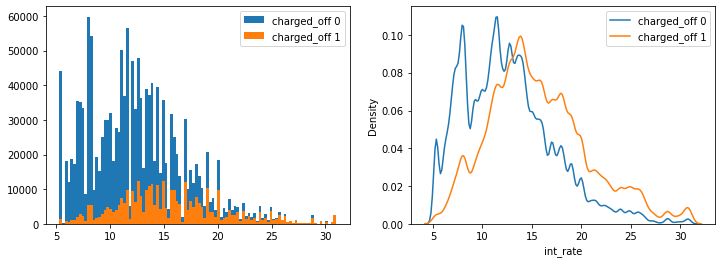

In [ ]:
fig, ax = plt.subplots(1, 2, figsize=(12,4))
for key, grp in data.groupby(['charged_off']):
    _ = ax[0].hist(grp['int_rate'], bins=100, label='charged_off {}'.format(key))

for key, grp in data.groupby(['charged_off']):
    sns.kdeplot(x=grp['int_rate'], ax=ax[1], label='charged_off {}'.format(key))

ax[0].legend()
ax[1].legend()
plt.show()

#### term

In [ ]:
data['term'] = data['term'].str.replace('months', '')
data['term'] = data['term'].str.replace(' ', '')

#### addr_state

In [ ]:
# data['addr_state'].value_counts(dropna=False)

In [ ]:
keep_state = data['addr_state'].value_counts(normalize=True)[:10].index.tolist()
keep_state = set(keep_state)
print(keep_state)

{'TX', 'NY', 'NJ', 'GA', 'IL', 'NC', 'OH', 'PA', 'CA', 'FL'}


In [ ]:
data.loc[~data['addr_state'].isin(keep_state), 'addr_state'] = 'Other'

In [ ]:
data['addr_state'].value_counts(normalize=True)

Other    0.420533
CA       0.142159
TX       0.082219
NY       0.081104
FL       0.071819
IL       0.039030
NJ       0.035996
PA       0.033734
OH       0.032865
GA       0.032562
NC       0.027979
Name: addr_state, dtype: float64

#### emp_title

In [ ]:
data.loc[data['emp_title'].isnull(), 'emp_title'] = 'Other'

In [ ]:
data.loc[data['emp_title']=='RN', 'emp_title'] = 'Nurse'
data.loc[data['emp_title'].str.contains('Nurse'), 'emp_title'] = 'Nurse'
data.loc[data['emp_title'].str.contains('nurse'), 'emp_title'] = 'Nurse'


In [ ]:
data.loc[data['emp_title'].str.contains('Manager'), 'emp_title'] = 'Manager'
data.loc[data['emp_title'].str.contains('manager'), 'emp_title'] = 'Manager'

In [ ]:
data.loc[data['emp_title']=='owner', 'emp_title'] = 'Owner'
data.loc[data['emp_title']=='driver', 'emp_title'] = 'Driver'
data.loc[data['emp_title'].str.contains('Driver'), 'emp_title'] = 'Driver'
data.loc[data['emp_title'].str.contains('driver'), 'emp_title'] = 'Driver'

In [ ]:
data.loc[data['emp_title']=='teacher', 'emp_title'] = 'Teacher'
data.loc[data['emp_title']=='sales', 'emp_title'] = 'Sales'
data.loc[data['emp_title']=='supervisor', 'emp_title'] = 'Supervisor'


In [ ]:
keep_emp_titles = data['emp_title'].value_counts(normalize=True)[:10].index.tolist()
keep_emp_titles = set(keep_emp_titles)
print(keep_emp_titles)

{'Director', 'Sales', 'Manager', 'Owner', 'Teacher', 'Driver', 'Supervisor', 'Nurse', 'Engineer', 'Other'}


In [ ]:
data.loc[~data['emp_title'].isin(keep_emp_titles), 'emp_title'] = 'Other'

In [ ]:
data['emp_title'].value_counts(normalize=True)

Other         0.767404
Manager       0.130653
Nurse         0.025919
Driver        0.021987
Teacher       0.019499
Owner         0.012110
Supervisor    0.007907
Sales         0.007487
Director      0.003793
Engineer      0.003241
Name: emp_title, dtype: float64

In [ ]:
# data.drop(columns=['emp_title'], inplace=True, errors='ignore')
to_del_columns.append('emp_title')

#### emp_length

In [ ]:
## convert strings to integers
data.loc[data['emp_length']=='10+ years', 'emp_length'] = 10
data.loc[data['emp_length']=='< 1 year', 'emp_length'] = 0
data.loc[data['emp_length']=='1 year', 'emp_length'] = 1
for i in range(2, 10):
    data.loc[data['emp_length']== str(i)+' years', 'emp_length'] = i

In [ ]:
# data.loc[data['emp_length'].isnull(), 'ind_emp_length'] = 1
# data.loc[~data['emp_length'].isnull(), 'ind_emp_length'] = 0

In [ ]:
data['emp_length'] = data['emp_length'].fillna(data['emp_length'].median())

In [ ]:
data['emp_length'].value_counts(dropna=False)

10.0    611330
6.0     202550
2.0     168516
0.0     153700
3.0     149271
1.0     122924
5.0     115872
4.0     112211
8.0      78646
7.0      78141
9.0      67170
Name: emp_length, dtype: int64

#### home_ownership

In [ ]:
data['home_ownership'].replace(['NONE', 'ANY'], 'OTHER', inplace=True)

In [ ]:
data['home_ownership'].value_counts(dropna=False)

MORTGAGE    918028
RENT        735358
OWN         205578
OTHER         1367
Name: home_ownership, dtype: int64

#### annual_inc

In [ ]:
data['annual_inc'].describe()

count    1.860331e+06
mean     7.736956e+04
std      1.178218e+05
min      0.000000e+00
25%      4.600000e+04
50%      6.500000e+04
75%      9.200000e+04
max      1.100000e+08
Name: annual_inc, dtype: float64

In [ ]:
## clip
data.loc[data['annual_inc']>1000000, 'annual_inc'] = 1000000

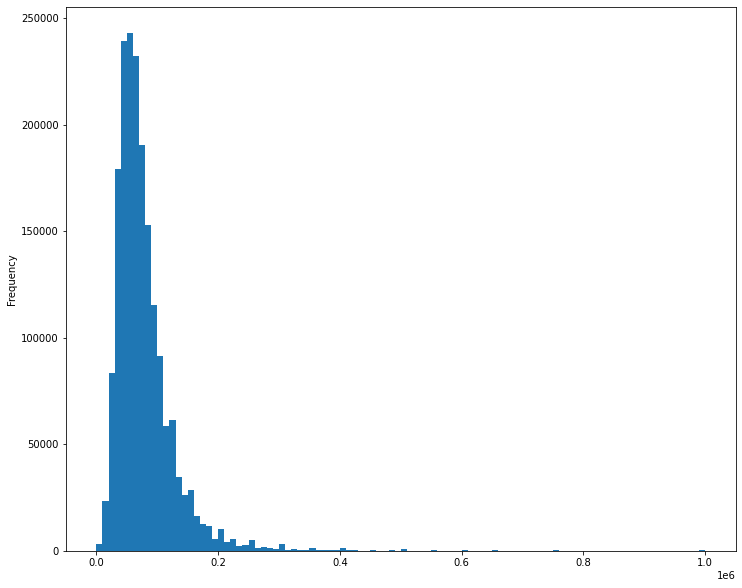

In [ ]:
data['annual_inc'].plot(kind='hist', bins=100)

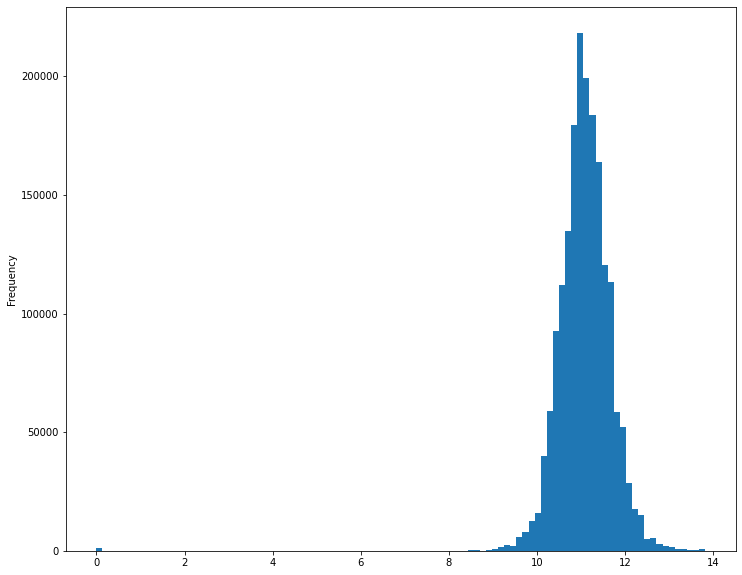

In [ ]:
data['log_annual_inc'] = data['annual_inc'].apply(np.log1p)
data['log_annual_inc'].plot(kind='hist', bins=100)

In [ ]:
data.drop(columns=['annual_inc'], inplace=True, errors='ignore')

#### dti

In [ ]:
data['dti'].describe()

count    1.859223e+06
mean     1.856774e+01
std      1.309153e+01
min     -1.000000e+00
25%      1.182000e+01
50%      1.771000e+01
75%      2.429000e+01
max      9.990000e+02
Name: dti, dtype: float64

In [ ]:
## outliers 
data.loc[(data['dti']==-1) | (data['dti']>=600), 'dti'] = data['dti'].median()

In [ ]:
## fill NA
data['dti'] = data['dti'].fillna(data['dti'].median())

In [ ]:
data['dti'].describe()

count    1.860331e+06
mean     1.849887e+01
std      1.044793e+01
min      0.000000e+00
25%      1.183000e+01
50%      1.771000e+01
75%      2.428000e+01
max      5.952400e+02
Name: dti, dtype: float64

#### earliest_cr_line

earliest_cr_line: The month the borrower's earliest reported credit line was opened

It is transformed into the time elapsed (in months) from earliest_cr_line to the issue_d. 

In [ ]:
data['earliest_cr_line'] = pd.to_datetime(data['earliest_cr_line'])
data['earliest_cr_line'].value_counts(dropna=False)

2003-09-01    12568
2004-09-01    12561
2001-08-01    12170
2002-08-01    12113
2003-08-01    12027
              ...  
1951-12-01        1
1952-07-01        1
1952-11-01        1
1955-11-01        1
1949-06-01        1
Name: earliest_cr_line, Length: 763, dtype: int64

In [ ]:
# data = data.dropna(axis=0, subset=['earliest_cr_line'])
data['earliest_cr_line'] = data['earliest_cr_line'].fillna(data['earliest_cr_line'].mode()[0])

In [ ]:
data['mths_sin_earliest_cr_line'] = ((data['issue_d'] - data['earliest_cr_line'])/np.timedelta64(1, 'M')).astype(int)
data[['earliest_cr_line', 'issue_d', 'mths_sin_earliest_cr_line']]
data[['earliest_cr_line', 'issue_d']]

earliest_cr_line    issue_d
39785       2003-10-01 2007-06-01
39775       1996-06-01 2007-07-01
39772       1997-02-01 2007-07-01
39773       2000-09-01 2007-07-01
39774       1997-10-01 2007-07-01
...                ...        ...
7626        2008-05-01 2020-09-01
11703       2001-04-01 2020-09-01
11714       1994-05-01 2020-09-01
12036       1991-03-01 2020-09-01
12024       2008-10-01 2020-09-01

[1860331 rows x 2 columns]

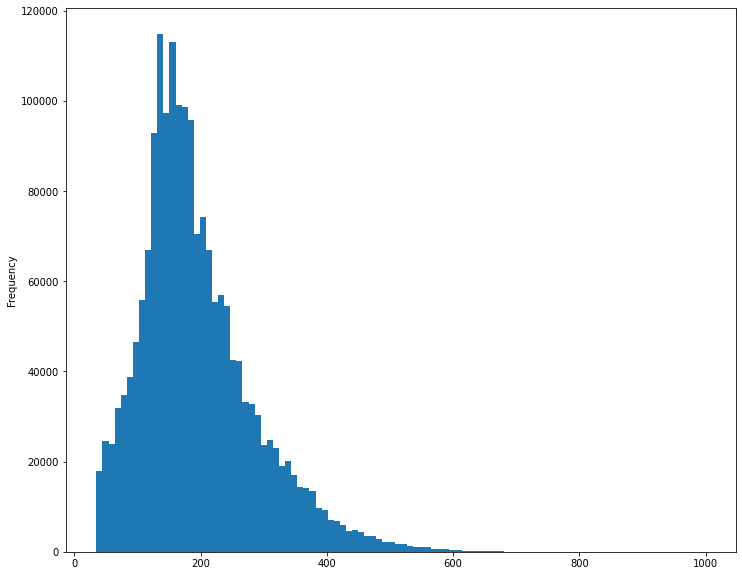

In [ ]:
data['mths_sin_earliest_cr_line'].plot(kind='hist', bins=100)

In [ ]:
# data.drop(columns=['earliest_cr_line'], inplace=True, errors='ignore')
to_del_columns.append('earliest_cr_line')

#### fico_range

In [ ]:
data[['fico_range_low', 'fico_range_high']].corr()

fico_range_low  fico_range_high
fico_range_low              1.0              1.0
fico_range_high             1.0              1.0

In [ ]:
# data.drop(columns=['fico_range_high'], axis=1, errors='ignore', inplace=True)
data.rename({'fico_range_low': 'fico'}, axis=1, inplace=True)
to_del_columns.append('fico_range_high')
# data.columns

#### revol_bal

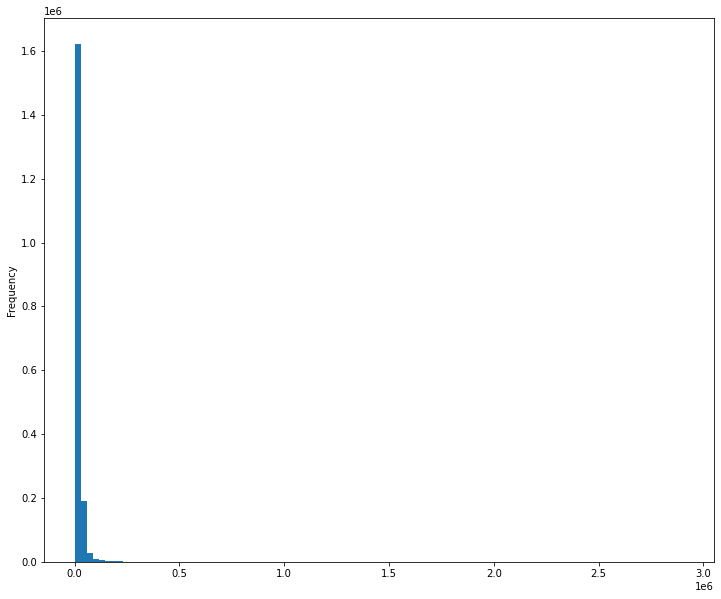

In [ ]:
data['revol_bal'].plot(kind='hist', bins=100)

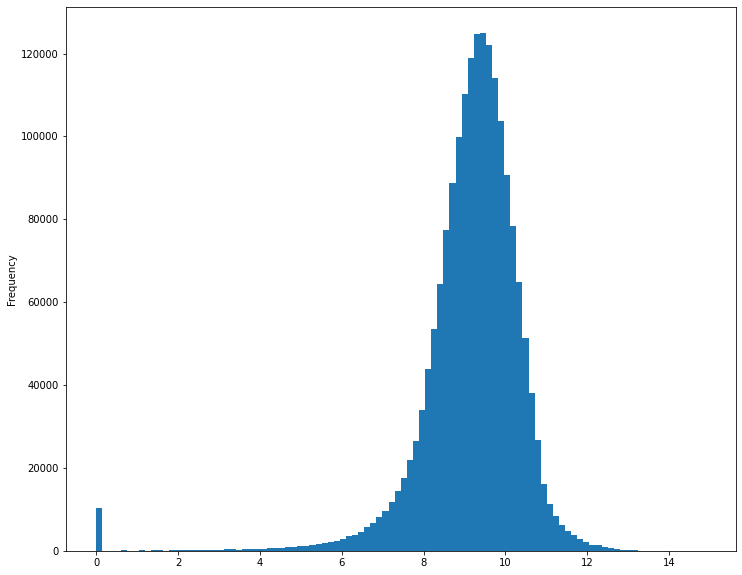

In [ ]:
data['revol_bal'].apply(np.log1p).plot(kind='hist', bins=100)

In [ ]:
data['log_revol_bal'] = data['revol_bal'].apply(np.log1p)

In [ ]:
# data.drop(columns=['revol_bal'], axis=1, inplace=True, errors='ignore')
to_del_columns.append('revol_bal')

#### revol_util

In [ ]:
data['revol_util'] = data['revol_util'].str.replace('%', '').astype(np.float64)
data['revol_util'] = data['revol_util'].fillna(data['revol_util'].median())

#### bc_util

In [ ]:
## fill NA
data['bc_util'] = data['bc_util'].fillna(data['bc_util'].median())

In [ ]:
data[['bc_util', 'revol_util']].corr()

bc_util  revol_util
bc_util     1.000000    0.843167
revol_util  0.843167    1.000000

In [ ]:
# data['bc_util'].plot(kind='hist', bins=100)

#### mort_acc

In [ ]:
# data['mort_acc'].value_counts(dropna=False)

missing values in mort_acc are filled with the mean of the group of total_acc. The assumption is that for the people with the same total_acc, they likely to have same percentage of mort_acc. 

In [ ]:
# data['ind_mort_acc'] = 0
# data.loc[data['mort_acc'].isnull(), 'ind_mort_acc'] = 1
# assert data['mort_acc'].isnull().sum()==data['ind_mort_acc'].sum()

In [ ]:
# total_acc_avg = data.groupby('total_acc').mean()['mort_acc'].fillna(0)
# total_acc_avg

In [ ]:
# data["mort_acc"] = data.groupby("total_acc").transform(lambda x: x.fillna(x.mean()))
data['mort_acc'] = data['mort_acc'].fillna(data.groupby('total_acc')['mort_acc'].transform('mean'))

#### pub_rec_bankruptcies

In [ ]:
## fill NA
data['pub_rec_bankruptcies'] = data['pub_rec_bankruptcies'].fillna(0.0)

#### delinq_2yrs

In [ ]:
# data['delinq_2yrs'].value_counts(dropna=False)
# data['delinq_2yrs'].plot(kind='hist', bins=50)

#### inq_last_6mths

In [ ]:
data['inq_last_6mths'] = data['inq_last_6mths'].fillna(0.0)
data['inq_last_6mths'].value_counts(dropna=False)

0.0    1100184
1.0     497346
2.0     176762
3.0      63228
4.0      16133
5.0       5652
6.0        956
7.0         48
8.0         22
Name: inq_last_6mths, dtype: int64

#### inq_last_12m

In [ ]:
data['inq_last_12m'] = data['inq_last_12m'].fillna(0.0)
## indicator variable: if inq_last_12m>0
data['ind_inq_last_12m'] = 0.0
data.loc[data.loc[:, 'inq_last_12m']>0.0, 'ind_inq_last_12m'] = 1

In [ ]:
to_del_columns.append('inq_last_12m')

#### mths_since_last_delinq

In [ ]:
data['mths_since_last_delinq'].value_counts(dropna=False)

NaN      945116
12.0      17448
13.0      17295
6.0       17249
9.0       17049
          ...  
157.0         1
156.0         1
143.0         1
128.0         1
180.0         1
Name: mths_since_last_delinq, Length: 174, dtype: int64

In [ ]:
clip_lower = 0.0
clip_upper = 120.0
data['mths_since_last_delinq'] = data['mths_since_last_delinq'].fillna(clip_upper)
data['mths_since_last_delinq'] = data['mths_since_last_delinq'].clip(lower=clip_lower, 
                                                                     upper=clip_upper)
data['mths_since_last_delinq'].value_counts(dropna=False)

120.0    945299
12.0      17448
13.0      17295
6.0       17249
9.0       17049
          ...  
112.0        18
118.0        15
116.0        14
119.0        12
117.0        10
Name: mths_since_last_delinq, Length: 121, dtype: int64

#### platform-dependent grade (rating)

In [ ]:
data.drop(columns=['grade', 'sub_grade'], axis=1, inplace=True, errors='ignore')
# data.drop(columns=['grade'], axis=1, inplace=True, errors='ignore')

#### initial_list_status

In [ ]:
data['initial_list_status'].value_counts(dropna=False)

w    1194912
f     665419
Name: initial_list_status, dtype: int64

In [ ]:
data['initial_list_status'] = data['initial_list_status'].fillna(data['initial_list_status'].mode()[0])
# data['initial_list_status'].value_counts(dropna=False)

#### mo_sin_old_il_acct

No obvious difference between the distributions of Charged-Off and Fully Paid

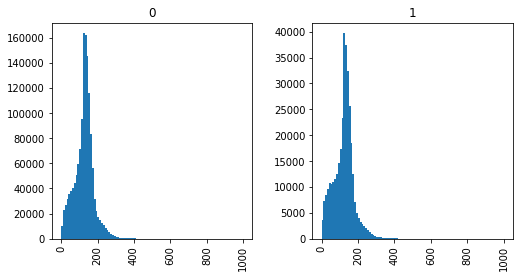

In [ ]:
_ = data['mo_sin_old_il_acct'].hist(bins=100, by=data['charged_off'], figsize=(8,4))

In [ ]:
# fig, ax = plt.subplots(1, figsize=(6, 4))
# _ = data.loc[data['charged_off']==0, 'mo_sin_old_il_acct'].plot.kde()
# _ = data.loc[data['charged_off']==1, 'mo_sin_old_il_acct'].plot.kde()
# plt.legend(labels=['paid_off', 'charged_off'])

In [ ]:
to_del_columns.append('mo_sin_old_il_acct')

#### mo_sin_old_rev_tl_op

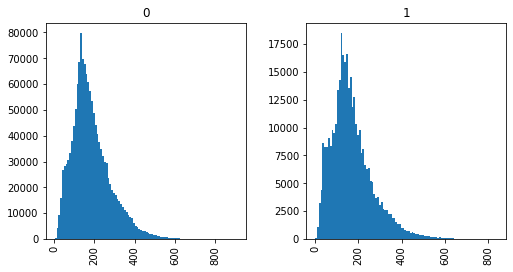

In [ ]:
_ = data['mo_sin_old_rev_tl_op'].hist(bins=100, by=data['charged_off'], figsize=(8,4))

In [ ]:
# fig, ax = plt.subplots(1, figsize=(6, 4))
# _ = data.loc[data['charged_off']==0, 'mo_sin_old_rev_tl_op'].plot.kde()
# _ = data.loc[data['charged_off']==1, 'mo_sin_old_rev_tl_op'].plot.kde()
# plt.legend(labels=['paid_off', 'charged_off'])

In [ ]:
to_del_columns.append('mo_sin_old_rev_tl_op')

#### mths_since_last_major_derog

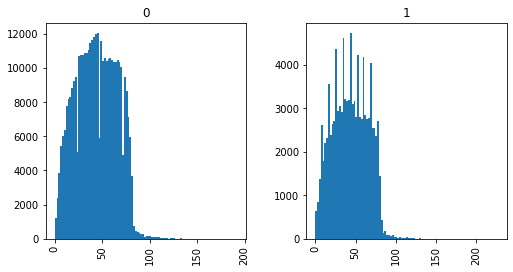

In [ ]:
_ = data['mths_since_last_major_derog'].hist(bins=100, by=data['charged_off'], figsize=(8,4))

In [ ]:
# fig, ax = plt.subplots(1, figsize=(6, 4))
# _ = data.loc[data['charged_off']==0, 'mths_since_last_major_derog'].plot.kde()
# _ = data.loc[data['charged_off']==1, 'mths_since_last_major_derog'].plot.kde()
# plt.legend(labels=['paid_off', 'charged_off'])

In [ ]:
to_del_columns.append('mths_since_last_major_derog')

#### mths_since_rcnt_il

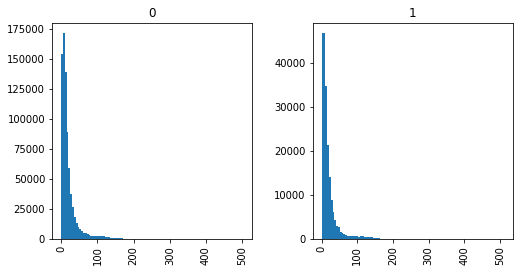

In [ ]:
_ = data['mths_since_rcnt_il'].hist(bins=100, by=data['charged_off'], figsize=(8,4))

In [ ]:
# fig, ax = plt.subplots(1, figsize=(6, 4))
# _ = data.loc[data['charged_off']==0, 'mths_since_rcnt_il'].plot.kde()
# _ = data.loc[data['charged_off']==1, 'mths_since_rcnt_il'].plot.kde()
# plt.legend(labels=['paid_off', 'charged_off'])

In [ ]:
to_del_columns.append('mths_since_rcnt_il')

#### mths_since_recent_bc_dlq

In [ ]:
data['mths_since_recent_bc_dlq'].value_counts(dropna=False)

NaN      1424524
26.0        6723
28.0        6629
25.0        6583
29.0        6536
          ...   
176.0          1
150.0          1
143.0          1
160.0          1
198.0          1
Name: mths_since_recent_bc_dlq, Length: 177, dtype: int64

In [ ]:
clip_lower = 0.0
clip_upper = 120.0
data['mths_since_recent_bc_dlq'] = data['mths_since_recent_bc_dlq'].fillna(clip_upper)
data['mths_since_recent_bc_dlq'] = data['mths_since_recent_bc_dlq'].clip(lower=clip_lower, 
                                                                     upper=clip_upper)
data['mths_since_recent_bc_dlq'].value_counts(dropna=False)

120.0    1424787
26.0        6723
28.0        6629
25.0        6583
29.0        6536
          ...   
116.0         26
114.0         23
118.0         22
119.0         20
117.0         10
Name: mths_since_recent_bc_dlq, Length: 121, dtype: int64

In [ ]:
# fig, ax = plt.subplots(1, figsize=(6, 4))
# _ = data.loc[(data.loc[:, 'mths_since_recent_bc_dlq']<90) & (data.loc[:, 'charged_off']==0), 'mths_since_recent_bc_dlq'].plot.kde()
# _ = data.loc[(data.loc[:, 'mths_since_recent_bc_dlq']<90) & (data.loc[:, 'charged_off']==1), 'mths_since_recent_bc_dlq'].plot.kde()
# plt.legend(labels=['paid_off', 'charged_off'])

#### mths_since_recent_revol_delinq

In [ ]:
data['mths_since_recent_revol_delinq'].value_counts(dropna=False)

NaN      1242670
13.0       11224
12.0       11182
14.0       10818
15.0       10684
          ...   
157.0          1
202.0          1
147.0          1
150.0          1
188.0          1
Name: mths_since_recent_revol_delinq, Length: 177, dtype: int64

In [ ]:
clip_lower = 0.0
clip_upper = 120.0
data['mths_since_recent_revol_delinq'] = data['mths_since_recent_revol_delinq'].fillna(clip_upper)
data['mths_since_recent_revol_delinq'] = data['mths_since_recent_revol_delinq'].clip(lower=clip_lower, 
                                                                     upper=clip_upper)
data['mths_since_recent_revol_delinq'].value_counts(dropna=False)

120.0    1242974
13.0       11224
12.0       11182
14.0       10818
15.0       10684
          ...   
116.0         31
115.0         31
118.0         26
119.0         24
117.0         20
Name: mths_since_recent_revol_delinq, Length: 121, dtype: int64

In [ ]:
# fig, ax = plt.subplots(1, figsize=(6, 4))
# _ = data.loc[(data.loc[:, 'mths_since_recent_revol_delinq']<90) & (data.loc[:, 'charged_off']==0), 'mths_since_recent_revol_delinq'].plot.kde()
# _ = data.loc[(data.loc[:, 'mths_since_recent_revol_delinq']<90) & (data.loc[:, 'charged_off']==1), 'mths_since_recent_revol_delinq'].plot.kde()
# plt.legend(labels=['paid_off', 'charged_off'])

#### drop some columns

In [ ]:
to_del_columns.append('loan_amnt') ## high correlation with installment
to_del_columns

['emp_title',
 'earliest_cr_line',
 'fico_range_high',
 'revol_bal',
 'inq_last_12m',
 'mo_sin_old_il_acct',
 'mo_sin_old_rev_tl_op',
 'mths_since_last_major_derog',
 'mths_since_rcnt_il',
 'loan_amnt']

In [ ]:
data.drop(columns=to_del_columns, inplace=True, errors='ignore')

#### Check NA values

In [ ]:
data.isnull().sum().sum()

0

In [ ]:
# percent_missing = pd.DataFrame(data.isnull().sum()*100/ len(data), columns=['missing percentage'])
# percent_missing.sort_values(by='missing percentage', ascending=False, inplace=True)
# percent_missing

## Correlation

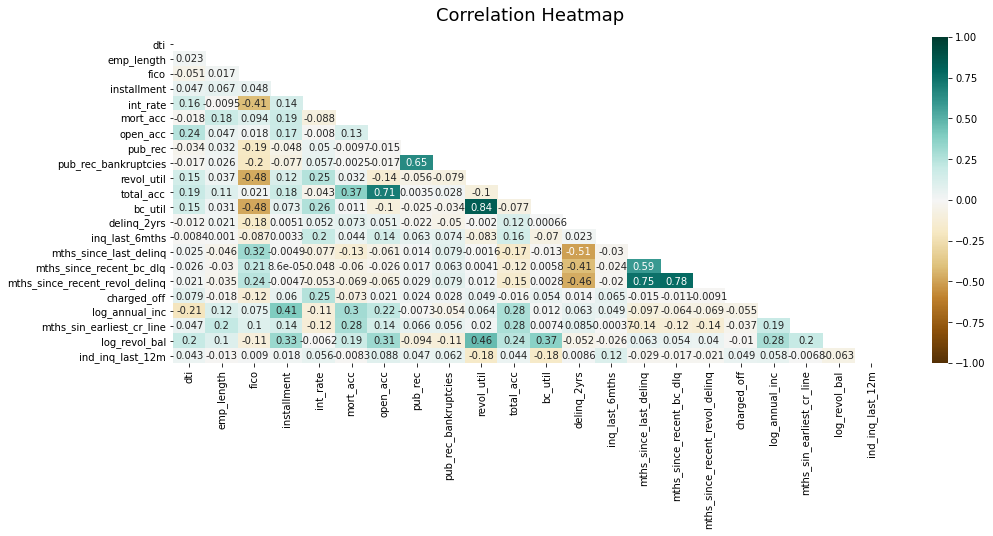

In [ ]:
plt.figure(figsize=(16, 6))
# define the mask to set the values in the upper triangle to True
mask = np.triu(np.ones_like(data.corr(), dtype=np.bool))
heatmap = sns.heatmap(data.corr(), mask=mask, vmin=-1, vmax=1, annot=True, cmap='BrBG')
heatmap.set_title('Correlation Heatmap', fontdict={'fontsize':18}, pad=16);

## Train/test data 

In [ ]:
## used for GAM
data_copy = data.copy()

#### Encoding categorical features

In [ ]:
num_cols = [col for col, type_ in zip(data.dtypes.index, data.dtypes.values) if type_==np.float or type_==np.int]
print('num_cols', num_cols)
cat_cols = [col for col in data.dtypes.index if col not in num_cols]
cat_cols.remove('issue_d') ## issue_d will not be used as a feature
print('cat_cols', cat_cols)

num_cols ['dti', 'emp_length', 'fico', 'installment', 'int_rate', 'mort_acc', 'open_acc', 'pub_rec', 'pub_rec_bankruptcies', 'revol_util', 'total_acc', 'bc_util', 'delinq_2yrs', 'inq_last_6mths', 'mths_since_last_delinq', 'mths_since_recent_bc_dlq', 'mths_since_recent_revol_delinq', 'charged_off', 'log_annual_inc', 'mths_sin_earliest_cr_line', 'log_revol_bal', 'ind_inq_last_12m']
cat_cols ['addr_state', 'application_type', 'home_ownership', 'purpose', 'term', 'verification_status', 'initial_list_status']


In [ ]:
for cat_col in cat_cols:
    print(cat_col, data[cat_col].nunique())

addr_state 11
application_type 2
home_ownership 4
purpose 14
term 2
verification_status 3
initial_list_status 2


In [ ]:
data = pd.get_dummies(data, columns=cat_cols)
data.shape

(1860331, 61)

In [ ]:
data.head()

dti  emp_length  ... initial_list_status_f  initial_list_status_w
39785  14.29         0.0  ...                     1                      0
39775   5.55         0.0  ...                     1                      0
39772   0.00         2.0  ...                     1                      0
39773  14.54         0.0  ...                     1                      0
39774   2.29         8.0  ...                     1                      0

[5 rows x 61 columns]

#### Train/test split

Text(0.5, 1.0, 'Loans Funded per Year')

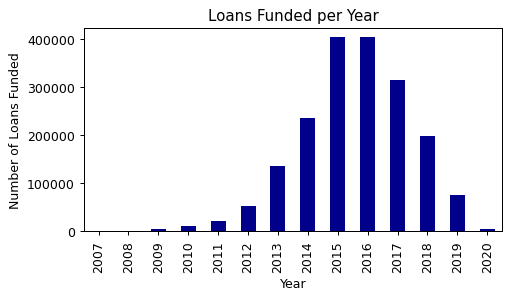

In [ ]:
plt.figure(figsize=(6,3), dpi=90)
data['issue_d'].dt.year.value_counts().sort_index().plot.bar(color='darkblue')
plt.xlabel('Year')
plt.ylabel('Number of Loans Funded')
plt.title('Loans Funded per Year')

In [ ]:
# time_split = data['issue_d'].quantile(0.9)
time_begin = pd.to_datetime('2012-01-01')
time_split = pd.to_datetime('2018-06-01')
time_end = pd.to_datetime('2020-01-01')

data_train = data.loc[data['issue_d']>=time_begin, :]
data_train = data_train.loc[data_train['issue_d']<=time_split, :]
data_test = data.loc[(data['issue_d']<=time_end), :]
data_test = data_test.loc[data_test['issue_d']>time_split, :]

print('train data period', data_train['issue_d'].dt.date.min(), data_train['issue_d'].dt.date.max())
print('test data period', data_test['issue_d'].dt.date.min(), data_test['issue_d'].dt.date.max())

train data period 2012-01-01 2018-06-01
test data period 2018-07-01 2020-01-01


In [ ]:
X_train = data_train.drop(columns=['charged_off', 'issue_d'])
y_train = data_train['charged_off'].values
issue_d_train = data_train['issue_d']
feature_names = X_train.columns.to_list()
X_train.shape, y_train.shape

((1654644, 59), (1654644,))

In [ ]:
X_test = data_test.drop(columns=['charged_off', 'issue_d'])
y_test = data_test['charged_off'].values
issue_d_test= data_test['issue_d']
X_test.shape, y_test.shape

((163259, 59), (163259,))

In [ ]:
# data.drop(columns=['issue_d'], inplace=True, errors='ignore')
# data_train.drop(columns=['issue_d'], inplace=True, errors='ignore')
# data_test.drop(columns=['issue_d'], inplace=True, errors='ignore')

In [ ]:
# del df
# del df, data, data_train, data_test

#### Scale data

In [ ]:
scaler = MinMaxScaler() 
# fit and transfrom
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [ ]:
X_train.shape, y_train.shape

((1654644, 59), (1654644,))

In [ ]:
X_test.shape, y_test.shape

((163259, 59), (163259,))

#### Analyze class imbalance in the targets

In [ ]:
# https://www.tensorflow.org/tutorials/structured_data/imbalanced_data#calculate_class_weights
## Scaling by total/2 helps keep the loss to a similar magnitude.
# The sum of the weights of all examples stays the same.
counts = np.bincount(y_train)
print(
    "Number of positive samples in training data: {} ({:.2f}% of total)".format(
        counts[1], 100 * float(counts[1]) / len(y_train)
    )
)
total = counts[0]+counts[1]
weight_for_0 = 1.0 / counts[0] * (total / 2.0)
weight_for_1 = 1.0 / counts[1] * (total / 2.0)

Number of positive samples in training data: 323270 (19.54% of total)


In [ ]:
counts = np.bincount(y_test)
print(
    "Number of positive samples in test data: {} ({:.2f}% of total)".format(
        counts[1], 100 * float(counts[1]) / len(y_test)
    )
)

Number of positive samples in test data: 33581 (20.57% of total)


#### Create a train-test dataset for tuning hyperparameters



In [ ]:
## full-size dataset
size = X_train.shape[0]
X_full = np.concatenate([X_train, X_test])
y_full = np.concatenate([y_train, y_test])

## create a predefined split for validation data
test_fold = np.concatenate([
    np.full(y_train.shape[0], -1, dtype=np.int8),
    np.zeros(y_test.shape[0], dtype=np.int8)
])
cv = sklearn.model_selection.PredefinedSplit(test_fold) 

X_full.shape, y_full.shape

((1817903, 59), (1817903,))

## Bayesian Optimization for hyperparameters
https://github.com/fmfn/BayesianOptimization 

https://www.kaggle.com/clair14/tutorial-bayesian-optimization

#### Logistic Regression

##### Model Training

In [ ]:
timestr = time.strftime("%Y%m%d_%H%M%S")
saved_bay_opt_res_name = trained_model_folder_path+'bay_opt_logreg_res_'+timestr+'.csv'
saved_model_name = trained_model_folder_path+'bay_opt_logreg_model_'+timestr+'.pkl'

saved_model_name

'/content/drive/MyDrive/Colab Notebooks/Kaggle/LendingClub/trained_models/bay_opt_logreg_model_20210725_052909.pkl'

In [ ]:
def bayes_parameter_opt_logreg(X, y, 
                               cv=None,
                               init_round=15,
                               opt_round=25, 
                               random_seed=6):
    def logreg_eval(expC, l1_ratio):
        """
        Logistic regression cross validation.
        This function will instantiate a logistic regression classifier with parameters C and
        l1_ratio. Combined with data and targets this will in turn be used to perform
        cross validation. The result of cross validation is returned.
        Our goal is to find combinations of C and l1_ratio that maximizes the pr_auc (average_precision)
        metric.
        """
        params = {}
        ## 
        C = 10 ** expC
        params['C'] = C
        params['l1_ratio'] = l1_ratio

        ## fixed parameters
        params['penalty'] = 'elasticnet'
        params['class_weight'] = 'balanced'
        params['solver'] = 'saga'
        params['n_jobs'] = -1

        estimator = LogisticRegression(**params)
        cval = cross_val_score(estimator, X, y, scoring='average_precision', cv=cv)
        return cval.mean()

    # range 
    logregBO = BayesianOptimization(logreg_eval, {
                                                  'expC': (-3, 1), 
                                                  'l1_ratio': (0, 1)
                                                 }, 
                                    random_state=0)
    # optimize
    logregBO.maximize(init_points=init_round, n_iter=opt_round)
    
    return logregBO

In [ ]:
# %%time
# print('target: pr-auc')
# logregBO = bayes_parameter_opt_logreg(X_full, y_full, 
#                                       cv=cv, 
#                                       init_round=5, 
#                                       opt_round=15)

# logregBO_res = pd.DataFrame(logregBO.res)
# logregBO_res.to_csv(saved_bay_opt_res_name)
# saved_bay_opt_res_name

In [ ]:
# logregBO_res = pd.read_csv(saved_bay_opt_res_name)
logregBO_res = pd.read_csv(trained_model_folder_path+'bay_opt_logreg_res_20210720_053455.csv')
best_params = logregBO_res.sort_values(by='target', ascending=False).reset_index().loc[0, 'params']
best_params = best_params.replace("'", '"')
best_params = json.loads(best_params)
best_params = dict(best_params)

C = 10 ** best_params['expC']
best_params['C'] = C
del best_params['expC']

## fixed parameters
best_params['penalty'] = 'elasticnet'
best_params['class_weight'] = 'balanced'
best_params['solver'] = 'saga'
best_params['n_jobs'] = -1

best_params

{'C': 0.0012607899739767038,
 'class_weight': 'balanced',
 'l1_ratio': 0.005048589427872452,
 'n_jobs': -1,
 'penalty': 'elasticnet',
 'solver': 'saga'}

In [ ]:
# logreg = LogisticRegression(**best_params)
# logreg.fit(X_train, y_train)
# joblib.dump(logreg, saved_model_name)

In [ ]:
# logreg = joblib.load(saved_model_name)
saved_model_name = trained_model_folder_path+'bay_opt_logreg_model_20210720_053455.pkl'
logreg = joblib.load(saved_model_name)

In [ ]:
y_pred = logreg.predict_proba(X_test)[:, 1]
print('evaluation on test data')
print('pr-auc', sklearn.metrics.average_precision_score(y_test, y_pred))
print('roc-auc', sklearn.metrics.roc_auc_score(y_test, y_pred))

evaluation on test data
pr-auc 0.3491521251966679
roc-auc 0.6891887175477707


##### Evaluation

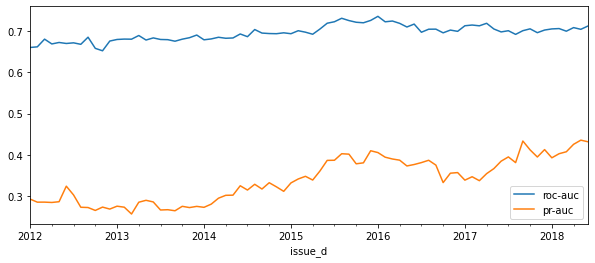

In [ ]:
y_pred_train = logreg.predict_proba(X_train)[:, 1]
df_train= pd.DataFrame(data=issue_d_train)
df_train['y_train'] = y_train
df_train['y_pred_train'] = y_pred_train.flatten()

df_train_aucs = df_train.groupby('issue_d').apply(lambda s: pd.Series({ 
    "charged_off_rate": s['y_train'].mean(),
    "roc-auc": my_roc_auc_score(s['y_train'], s['y_pred_train']), 
    "pr-auc": sklearn.metrics.average_precision_score(s['y_train'], s['y_pred_train']), 
}))
df_train_aucs[['roc-auc', 'pr-auc']].plot(figsize=(10, 4))

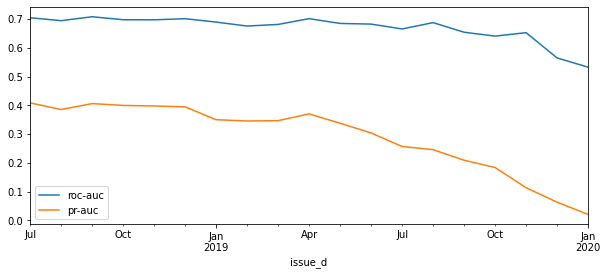

In [ ]:
y_pred_test = logreg.predict_proba(X_test)[:, 1]
df_test= pd.DataFrame(data=issue_d_test)
df_test['y_test'] = y_test
df_test['y_pred_test'] = y_pred_test.flatten()
df_test

df_test_aucs = df_test.groupby('issue_d').apply(lambda s: pd.Series({ 
    "charged_off_rate": s['y_test'].mean(),
    "roc-auc": my_roc_auc_score(s['y_test'], s['y_pred_test']), 
    "pr-auc": sklearn.metrics.average_precision_score(s['y_test'], s['y_pred_test']), 
}))
# df_test_aucs
df_test_aucs[['roc-auc', 'pr-auc']].plot(figsize=(10, 4))

#### XGBoost

##### Model Training

In [ ]:
timestr = time.strftime("%Y%m%d_%H%M%S")
saved_bay_opt_res_name = trained_model_folder_path+'bay_opt_xgb_res_'+timestr+'.csv'
saved_model_name = trained_model_folder_path+'bay_opt_xgb_model_'+timestr+'.pkl'

saved_model_name

'/content/drive/MyDrive/Colab Notebooks/Kaggle/LendingClub/trained_models/bay_opt_xgb_model_20210725_052912.pkl'

In [ ]:
def bayes_parameter_opt_xgb(X, y,
                            cv, 
                            init_round=15, 
                            opt_round=25, 
                            random_seed=6):
    '''
    Bayesian optimization for XGBoost hyperparameters  
    reference: https://analyticsindiamag.com/implementing-bayesian-optimization-on-xgboost-a-beginners-guide/
    '''
    #Converting the dataframe into XGBoost’s Dmatrix object
    dtrain = xgb.DMatrix(X, y)

    # parameters
    def xgb_eval(max_depth, 
                 gamma, 
                 num_boost_round, 
                 learning_rate, 
                 min_child_weight, 
                 subsample, 
                 colsample_bytree, 
                 reg_alpha, 
                 reg_lambda
                 ):
        
        params = {}
        POS_WEIGHT = 4 ## https://xgboost.readthedocs.io/en/latest/parameter.html

        ## parameters to be optimized
        params['max_depth'] = int(round(max_depth))
        params['gamma'] = gamma
        # params['num_boost_round'] = int(round(num_boost_round))
        params['learning_rate'] = learning_rate
        params['min_child_weight'] = min_child_weight
        params['subsample'] = max(min(subsample, 1), 0)
        params['colsample_bytree'] = max(min(colsample_bytree, 1), 0)
        params['reg_alpha'] = reg_alpha
        params['reg_lambda'] = reg_lambda

        ## fixed parameters
        params['tree_method'] = 'gpu_hist'
        params['eval_metric'] = 'aucpr'
        params['objective'] = 'binary:logistic'
        # params['n_gpus'] = 1
        # params['silent'] = 0
        params['scale_pos_weight'] =  POS_WEIGHT

        # print('params', params)
        ## using predefined validation set
        cv_result = xgb.cv(params, 
                            dtrain, 
                            folds=cv,
                            metrics='aucpr',
                            num_boost_round=int(round(num_boost_round)), 
                            early_stopping_rounds=20, 
                            )
        # print(cv_result)
        return max(cv_result['test-aucpr-mean'])

    # range 
    xgbBO = BayesianOptimization(xgb_eval, {
                                            'num_boost_round': (200, 2000), 
                                            'gamma': (0, 1),
                                            'learning_rate': (0.01, 0.1),
                                            'max_depth': (3, 12.5),
                                            'min_child_weight': (5, 50), 
                                            'subsample': (0, 1), 
                                            'colsample_bytree': (0, 1), 
                                            'reg_alpha': (0, 3), 
                                            'reg_lambda': (0, 3), 
                                            }, 
                                            random_state=0)
    # optimize
    xgbBO.maximize(init_points=init_round, n_iter=opt_round)
    
    return xgbBO


In [ ]:
# %%time
# print('target: pr-auc')
# xgbBO = bayes_parameter_opt_xgb(X_full, y_full, 
#                                 cv=cv, 
#                                 init_round=10, 
#                                 opt_round=10, 
#                                 random_seed=6)
# xgbBO_res = pd.DataFrame(xgbBO.res)
# xgbBO_res.to_csv(saved_bay_opt_res_name)
# saved_bay_opt_res_name

In [ ]:
xgbBO_res = pd.read_csv(trained_model_folder_path+'bay_opt_xgb_res_20210724_033216.csv')
# xgbBO_res = pd.read_csv(saved_bay_opt_res_name)
best_params = xgbBO_res.sort_values(by='target', ascending=False).reset_index().loc[0, 'params']
best_params = best_params.replace("'", '"')
best_params = json.loads(best_params)
best_params = dict(best_params)
best_params['max_depth'] = int(round(best_params['max_depth']))
best_params['num_boost_round'] = int(round(best_params['num_boost_round']))

## fixed parameters
POS_WEIGHT = 4
best_params['tree_method'] = 'gpu_hist'
# best_params['n_gpus'] = 1
best_params['eval_metric'] = 'aucpr'
best_params['objective'] = 'binary:logistic'
# best_params['silent'] = 0
best_params['scale_pos_weight'] =  POS_WEIGHT

best_params

{'colsample_bytree': 0.7275375427870149,
 'eval_metric': 'aucpr',
 'gamma': 0.5384048017946694,
 'learning_rate': 0.03714996515739294,
 'max_depth': 7,
 'min_child_weight': 33.59949978364565,
 'num_boost_round': 1028,
 'objective': 'binary:logistic',
 'reg_alpha': 1.4359516645010029,
 'reg_lambda': 1.2282569306478957,
 'scale_pos_weight': 4,
 'subsample': 0.9693580706832601,
 'tree_method': 'gpu_hist'}

In [ ]:
# %%time
# dtrain = xgb.DMatrix(X_train, label=y_train)
# dtest = xgb.DMatrix(X_test, label=y_test)
# xgbm = xgb.train(best_params,
#                 dtrain, 
#                 evals=[(dtest, 'test')], 
#                 num_boost_round=best_params['num_boost_round'], 
#                 early_stopping_rounds=20, 
#                 verbose_eval=100)

# joblib.dump(xgbm, saved_model_name)

In [ ]:
# xgbm = joblib.load(saved_model_name)

saved_model_name = trained_model_folder_path+'bay_opt_xgb_model_20210724_033216.pkl'
xgbm = joblib.load(saved_model_name)

In [ ]:
# y_pred = xgbm.predict_proba(X_test)[:, 1]
y_pred = xgbm.predict(xgb.DMatrix(X_test))
print('evaluation on test data')
print('pr-auc', sklearn.metrics.average_precision_score(y_test, y_pred))
print('roc-auc', sklearn.metrics.roc_auc_score(y_test, y_pred))

evaluation on test data
pr-auc 0.38875957396396993
roc-auc 0.7147894489154484


##### Evaluation

In [ ]:
## y_pred_train = lgbm.predict_proba(X_train, batch_size=1024)[:, 1].flatten()
# y_pred_train = xgbm.predict(xgb.DMatrix(X_train))
# df_train= pd.DataFrame(data=issue_d_train)
# df_train['y_train'] = y_train
# df_train['y_pred_train'] = y_pred_train.flatten()

# df_train_aucs = df_train.groupby('issue_d').apply(lambda s: pd.Series({ 
#     "charged_off_rate": s['y_train'].mean(),
#     "roc-auc": my_roc_auc_score(s['y_train'], s['y_pred_train']), 
#     "pr-auc": sklearn.metrics.average_precision_score(s['y_train'], s['y_pred_train']), 
# }))
# df_train_aucs[['roc-auc', 'pr-auc']].plot(figsize=(10, 4))

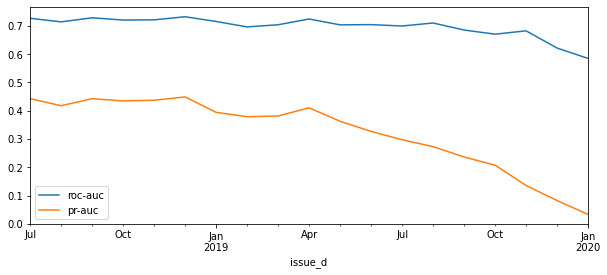

In [ ]:
# y_pred_test = xgbm.predict_proba(X_test)[:, 1].flatten()
y_pred_test = xgbm.predict(xgb.DMatrix(X_test))
df_test= pd.DataFrame(data=issue_d_test)
df_test['y_test'] = y_test
df_test['y_pred_test'] = y_pred_test.flatten()
df_test

df_test_aucs = df_test.groupby('issue_d').apply(lambda s: pd.Series({ 
    "charged_off_rate": s['y_test'].mean(),
    "roc-auc": my_roc_auc_score(s['y_test'], s['y_pred_test']), 
    "pr-auc": sklearn.metrics.average_precision_score(s['y_test'], s['y_pred_test']), 
}))
# df_test_aucs
df_test_aucs[['roc-auc', 'pr-auc']].plot(figsize=(10, 4))

##### Feature Importance

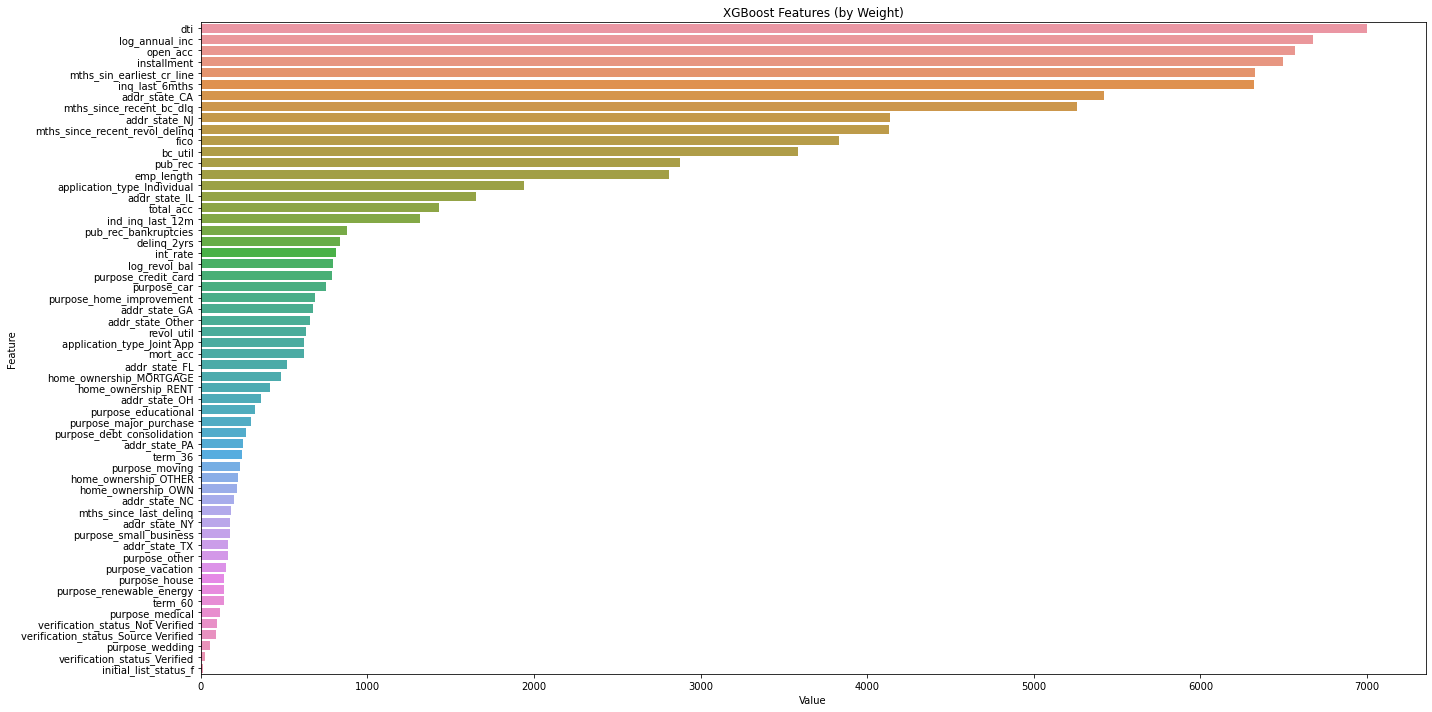

In [ ]:
# feature_imp = pd.DataFrame(sorted(zip(xgbm.feature_importances_, feature_names)), columns=['Value','Feature'])
feature_imp = pd.DataFrame(sorted(zip(xgbm.get_score(importance_type='weight').values(), feature_names)), columns=['Value','Feature'])

plt.figure(figsize=(20, 10))
sns.barplot(x="Value", y="Feature", data=feature_imp.sort_values(by="Value", ascending=False))
plt.title('XGBoost Features (by Weight)')
plt.tight_layout()
plt.show()

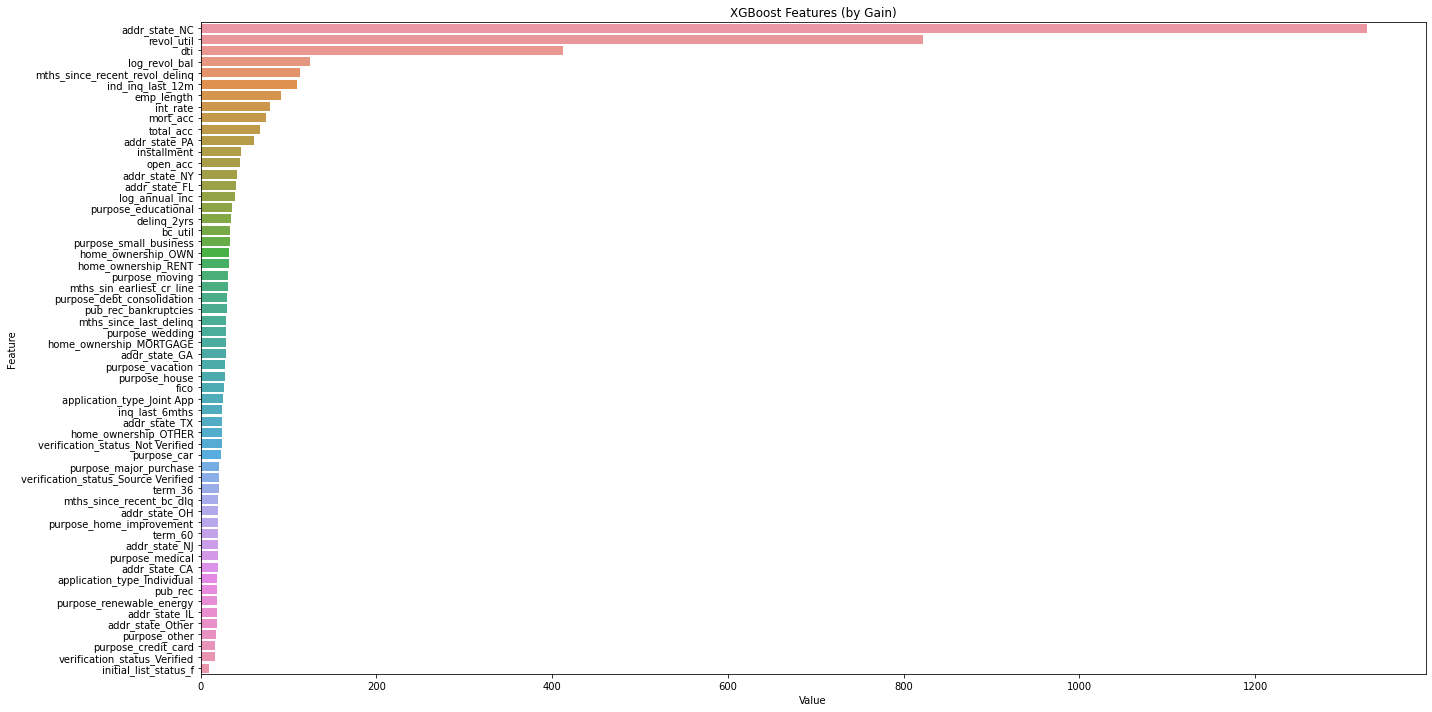

In [ ]:
feature_imp = pd.DataFrame(sorted(zip(xgbm.get_score(importance_type='gain').values(), feature_names)), columns=['Value','Feature'])

plt.figure(figsize=(20, 10))
sns.barplot(x="Value", y="Feature", data=feature_imp.sort_values(by="Value", ascending=False))
plt.title('XGBoost Features (by Gain)')
plt.tight_layout()
plt.show()

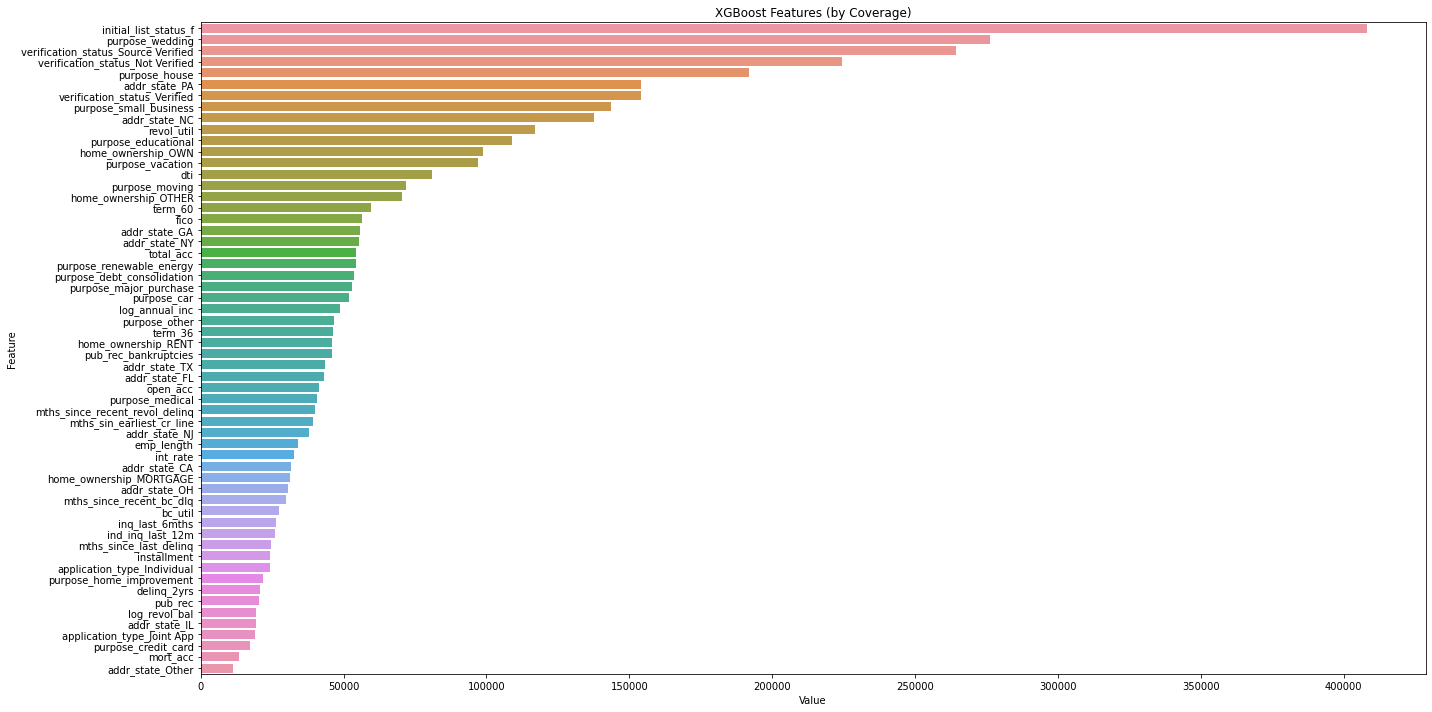

In [ ]:
feature_imp = pd.DataFrame(sorted(zip(xgbm.get_score(importance_type='cover').values(), feature_names)), columns=['Value','Feature'])

plt.figure(figsize=(20, 10))
sns.barplot(x="Value", y="Feature", data=feature_imp.sort_values(by="Value", ascending=False))
plt.title('XGBoost Features (by Coverage)')
plt.tight_layout()
plt.show()

##### Shap Values

reference: https://proceedings.neurips.cc/paper/2017/file/8a20a8621978632d76c43dfd28b67767-Paper.pdf

**Explanation of base value (explainer_expected_value)**

Base value: the mean of the model output over the background dataset. In other words, it would be predicted output if we did not know any features to the current output. (It can also be considered as a prior output.)

In practice, it can be computed based on


1.   the bias term of the model , i.e., the final columns the output from xgbm.predict(dsample, pred_contribs=True ;
2.   the mean of logit(p) in the train dataset, i.e., $\dfrac{1}{N} \sum_{i=1}^{N}logit(\hat{p}_{i})$, where $\hat{p}_{i}$ is the predicted probability of the $i$-th instance in the train dataset and $logit(p) = \log (\dfrac{p}{1-p}) = \beta_{0}+\beta_{1}f_{1}(x_{1})+\cdots$. 

reference: Page 5 on
https://proceedings.neurips.cc/paper/2017/file/8a20a8621978632d76c43dfd28b67767-Paper.pdf




In [ ]:
selected_indexes = np.random.choice(X_train.shape[0], 1000, replace=False)
X_sample = X_train[selected_indexes, :]
y_sample = y_train[selected_indexes]

dsample = xgb.DMatrix(X_sample)
xgbm.set_param({"predictor": "gpu_predictor"})
shap_values_with_bias = xgbm.predict(dsample, pred_contribs=True) ## the last element of each row is the bias term

y_pred_logit = xgbm.predict(dsample, output_margin=True)
y_pred_prob = xgbm.predict(dsample)
explainer_expected_value = shap_values_with_bias[0, -1]

assert np.allclose(y_pred_logit, shap_values_with_bias.sum(axis=1), rtol=1e-02) ## sum of shap values equal to y_pred_logit
assert np.allclose(tf.math.sigmoid(y_pred_logit), y_pred_prob, rtol=1e-02) ## sigmoid(y_pred_logit)==y_pred_probability

Explain feature importance for an instance in train data

In [ ]:
## example: label=0 (paid_off)

# print the JS visualization code to the notebook
shap.initjs()

idx = np.argwhere(1-y_sample)[0][0]
if y_sample[idx]==1.0:
    pred_class = 'charged_off'
else:
    pred_class = 'paid_off'
print('true label:', y_sample[idx], pred_class)
print('predicted charged-off probability', y_pred_prob[idx])
shap.force_plot(explainer_expected_value, 
                shap_values_with_bias[idx,:-1], 
                scaler.inverse_transform(np.atleast_2d(X_sample[idx,:])),
                feature_names=feature_names)

true label: 0 paid_off
predicted charged-off probability 0.10225252


In [ ]:
## example: label=1 (charged_off)

# print the JS visualization code to the notebook
shap.initjs()
idx = np.argwhere(y_sample)[0][0]
if y_sample[idx]==1.0:
    pred_class = 'charged_off'
else:
    pred_class = 'paid_off'
print('true label:', y_sample[idx], pred_class)
print('predicted charged-off probability', y_pred_prob[idx])
shap.force_plot(explainer_expected_value, 
                shap_values_with_bias[idx,:-1], 
                scaler.inverse_transform(np.atleast_2d(X_sample[idx,:])),
                feature_names=feature_names)

true label: 1 charged_off
predicted charged-off probability 0.30759


Explain feature importance for an instance in test data

In [ ]:
selected_indexes = np.random.choice(X_test.shape[0], 1000, replace=False)
X_sample = X_test[selected_indexes, :]
y_sample = y_test[selected_indexes]

dsample = xgb.DMatrix(X_sample)
xgbm.set_param({"predictor": "gpu_predictor"})
shap_values_with_bias = xgbm.predict(dsample, pred_contribs=True) ## the last element of each row is the bias term

y_pred_logit = xgbm.predict(dsample, output_margin=True)
y_pred_prob = xgbm.predict(dsample)
explainer_expected_value = shap_values_with_bias[0, -1]

assert np.allclose(y_pred_logit, shap_values_with_bias.sum(axis=1), rtol=1e-02) ## sum of shap values equal to y_pred_logit
assert np.allclose(tf.math.sigmoid(y_pred_logit), y_pred_prob, rtol=1e-02) ## sigmoid(y_pred_logit)==y_pred_probability

In [ ]:
## example: label=0 (paid_off)

# print the JS visualization code to the notebook
shap.initjs()
idx = np.argwhere(1-y_sample)[0][0]
if y_sample[idx]==1.0:
    pred_class = 'charged_off'
else:
    pred_class = 'paid_off'
print('true label:', y_sample[idx], pred_class)
print('predicted charged-off probability', y_pred_prob[idx])

shap.force_plot(explainer_expected_value, 
                shap_values_with_bias[idx,:-1], 
                scaler.inverse_transform(np.atleast_2d(X_sample[idx,:])),
                feature_names=feature_names)

true label: 0 paid_off
predicted charged-off probability 0.80680233


In [ ]:
## example: label=1 (charged_off)

# print the JS visualization code to the notebook
shap.initjs()
idx = np.argwhere(y_sample)[0][0]
if y_sample[idx]==1.0:
    pred_class = 'charged_off'
else:
    pred_class = 'paid_off'
print('true label:', y_sample[idx], pred_class)
print('predicted charged-off probability', y_pred_prob[idx])
shap.force_plot(explainer_expected_value,  
                shap_values_with_bias[idx,:-1], 
                scaler.inverse_transform(np.atleast_2d(X_sample[idx,:])),
                feature_names=feature_names)

true label: 1 charged_off
predicted charged-off probability 0.84552413


Explain feature importance for large amount of instances


1.   int_rate is the most important features, which has the largest mean absolute shap values computed for selected samples. 
2.   low int_rate mostly decreases the default probability, while there is a large portion of high int_rate that contributes to increase the default probability. 
3. term_36 has mostly negative shap values, i.e., decrease the default probability. 





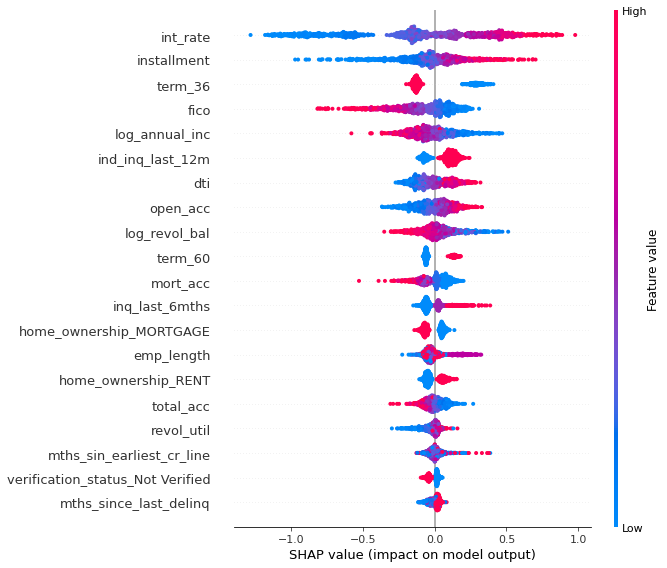

In [ ]:
shap.summary_plot(shap_values_with_bias[:,:-1], X_sample, feature_names=feature_names)

Dependence plot

In [ ]:
feature_names_index_map = {name: idx for idx, name in enumerate(feature_names)}
# feature_names_index_map

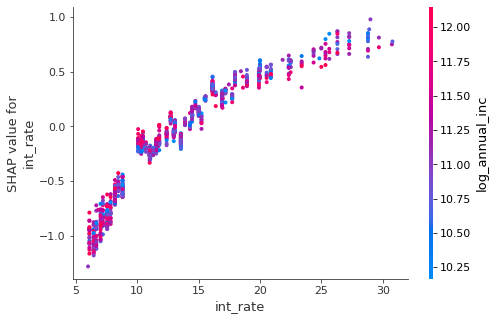

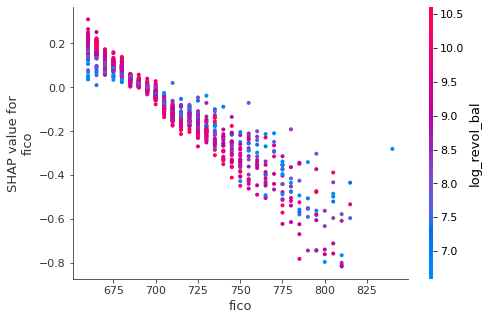

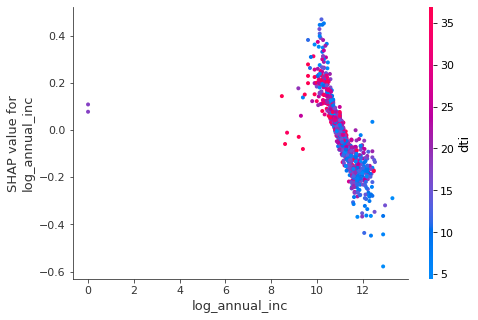

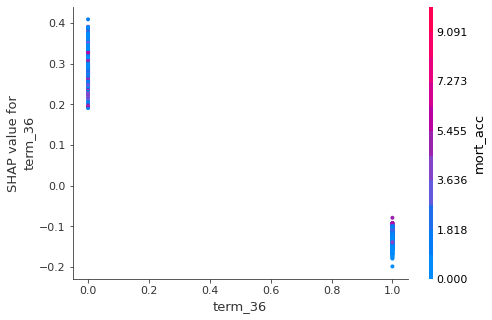

In [ ]:
for col_name in ['int_rate', 'fico', 'log_annual_inc', 'term_36']:
    shap.dependence_plot(feature_names_index_map[col_name], 
                        shap_values=shap_values_with_bias[:,:-1], 
                        features=scaler.inverse_transform(X_sample), 
                        feature_names=feature_names)

SHAP Interaction Values
https://shap.readthedocs.io/en/latest/example_notebooks/tabular_examples/tree_based_models/NHANES%20I%20Survival%20Model.html?highlight=dependence_plot#Compute-SHAP-Interaction-Values

https://xgboost.readthedocs.io/en/latest/gpu/index.html

https://christophm.github.io/interpretable-ml-book/shap.html

In [ ]:
# takes a couple minutes since SHAP interaction values take a factor of 2 * # features
# more time than SHAP values to compute, since this is just an example we only explain
# the first 100 people in order to run quicker

selected_indexes = np.random.choice(X_train.shape[0], 100, replace=False)
X_sample = X_train[selected_indexes, :]
y_sample = y_train[selected_indexes]

dsample = xgb.DMatrix(X_sample)
shap_interaction_values = xgbm.predict(dsample, pred_interactions=True)

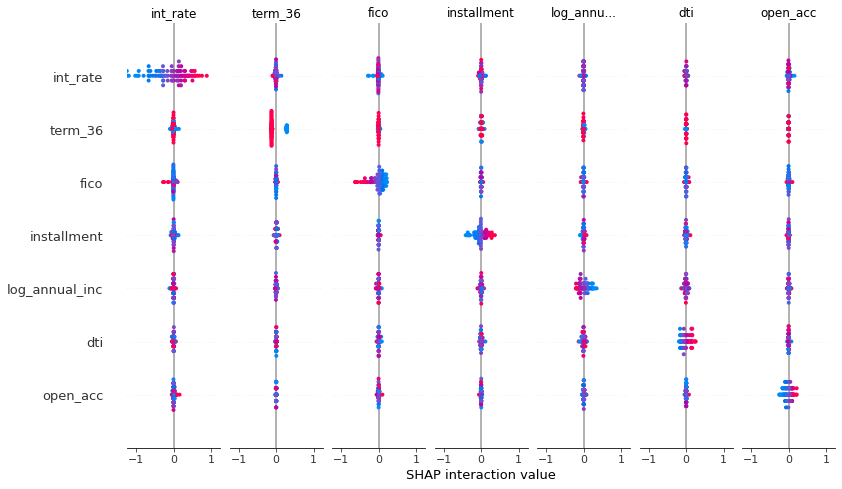

In [ ]:
shap.summary_plot(shap_interaction_values[:, :-1, :-1], 
                  X_sample, 
                  feature_names=np.array(feature_names))

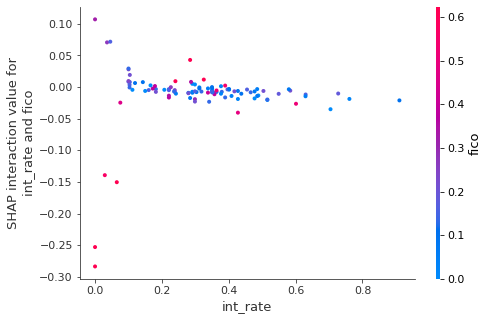

In [ ]:
shap.dependence_plot((feature_names_index_map['int_rate'], 
                      feature_names_index_map['fico']), 
                     shap_values=shap_interaction_values[:, :-1, :-1], 
                     features=X_sample,
                     feature_names=np.array(feature_names))

#### Light GBM

##### Model Training

In [ ]:
timestr = time.strftime("%Y%m%d_%H%M%S")
saved_bay_opt_res_name = trained_model_folder_path+'bay_opt_lgb_res_'+timestr+'.csv'
saved_model_name = trained_model_folder_path+'bay_opt_lgb_model_'+timestr+'.pkl'

saved_model_name

'/content/drive/MyDrive/Colab Notebooks/Kaggle/LendingClub/trained_models/bay_opt_lgb_model_20210725_052931.pkl'

In [ ]:
## custom metrics for Light GBM
def f_pr_auc(probas_pred, y_true):
    probas_pred = sigmoid(probas_pred)
    labels=y_true.get_label()
    p, r, _ = sklearn.metrics.precision_recall_curve(labels, probas_pred)
    score = sklearn.metrics.auc(r,p)
    return "pr_auc", score, True

def f_roc_auc(probas_pred, y_true):
    probas_pred = sigmoid(probas_pred)
    labels=y_true.get_label()
    p, r, _ = sklearn.metrics.roc_curve(labels, probas_pred)
    score = sklearn.metrics.auc(r,p)
    return "roc_auc", score, True

def bayes_parameter_opt_lgb(X, y, 
                            cv=None,
                            init_round=15, opt_round=25, 
                            n_folds=5, random_seed=6, 
                            output_process=False):
    '''
    Bayesian optimization for Light GBM hyperparameters  
    reference: https://www.kaggle.com/sz8416/simple-bayesian-optimization-for-lightgbm
    '''
    # prepare data
    # train_data = lgb.Dataset(data=X, label=y, categorical_feature = categorical_feats, free_raw_data=False)
    train_data = lgb.Dataset(data=X, label=y)
    # parameters
    def lgb_eval(n_estimators, learning_rate, num_leaves, feature_fraction, 
                 bagging_fraction, max_depth, lambda_l1, lambda_l2, 
                 min_split_gain, min_child_weight):
        
        params = {}
        params['num_iterations'] = int(round(n_estimators))
        params['learning_rate'] = learning_rate
        params["num_leaves"] = int(round(num_leaves))
        params['feature_fraction'] = max(min(feature_fraction, 1), 0)
        params['bagging_fraction'] = max(min(bagging_fraction, 1), 0)
        params['max_depth'] = int(round(max_depth))
        params['lambda_l1'] = max(lambda_l1, 0)
        params['lambda_l2'] = max(lambda_l2, 0)
        params['min_split_gain'] = min_split_gain
        params['min_child_weight'] = min_child_weight
        params["early_stopping_round"] = 50
        params["objective"] = "binary"
        params['metric'] = 'custom'
        # params['device'] = 'gpu'


        if cv is None:
            cv_result = lgb.cv(params, train_data, nfold=n_folds, 
                               seed=random_seed, stratified=True, 
                               verbose_eval =200, metrics=['auc'])
        else:
            ## using predefined validation set
            cv_result = lgb.cv(params, 
                                train_data, 
                                folds=cv,
                                seed=random_seed, 
                                feval=f_pr_auc,
                                ## for multiple custom metrics
                                # feval=lambda preds, y_true: [f_pr_auc(preds, y_true), 
                                #                                 f_roc_auc(preds, y_true)], 
                                # verbose_eval = 200
                                )
        return max(cv_result['pr_auc-mean'])

    # range 
    lgbBO = BayesianOptimization(lgb_eval, {'n_estimators': (200, 2000), 
                                            'num_leaves': (50, 500),
                                            'learning_rate': (0.01, 0.1),
                                            'feature_fraction': (0.1, 0.9),
                                            'bagging_fraction': (0.6, 1),
                                            'max_depth': (3, 10.5),
                                            'lambda_l1': (0, 5),
                                            'lambda_l2': (0, 3),
                                            'min_split_gain': (0.001, 0.1),
                                            'min_child_weight': (5, 50),
                                            # 'early_stopping_round': (50, 50.1)
                                            }, 
                                            random_state=0)
    # optimize
    lgbBO.maximize(init_points=init_round, n_iter=opt_round)
    
    # output optimization process
    # if output_process==True: lgbBO.points_to_csv("bayes_opt_result.csv")
    
    return lgbBO


In [ ]:
# %%time
# print('target: pr-auc')
# lgbBO = bayes_parameter_opt_lgb(X_full, y_full, 
#                                 cv=cv, 
#                                 init_round=5, 
#                                 opt_round=50, 
#                                 random_seed=6)

# lgbBO_res = pd.DataFrame(lgbBO.res)
# lgbBO_res.to_csv(saved_bay_opt_res_name)
# saved_bay_opt_res_name

In [ ]:
# # lgbBO_res = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/Kaggle/LendingClub/trained_models/bay_opt_lgb_res_20210718_003332.csv')
# lgbBO_res = pd.read_csv(saved_bay_opt_res_name)
# best_params = lgbBO_res.sort_values(by='target', ascending=False).reset_index().loc[0, 'params']
# best_params = best_params.replace("'", '"')
# best_params = json.loads(best_params)
# best_params = dict(best_params)
# best_params["num_leaves"] = int(round(best_params["num_leaves"]))
# best_params['max_depth'] = int(round(best_params['max_depth']))
# best_params['n_estimators'] = int(round(best_params['n_estimators']))
# best_params["early_stopping_round"] = 50
# best_params["objective"] = "binary"
# best_params['metric'] = 'custom'
# # best_params['device'] = 'gpu'

# best_params

In [ ]:
# ## custom pr auc function for training 
# def fit_pr_auc(y_true, probas_pred):
#     probas_pred = sigmoid(probas_pred)
#     # labels=y_true.get_label()
#     p, r, _ = sklearn.metrics.precision_recall_curve(y_true, probas_pred)
#     score = sklearn.metrics.auc(r,p)
#     return "pr_auc", score, True

# lgbm = lgb.LGBMClassifier(**best_params)
# lgbm.fit(X_train, y_train, 
#          eval_set=(X_test, y_test), 
#          eval_metric=fit_pr_auc,
#          verbose=False)
# joblib.dump(lgbm, saved_model_name)

In [ ]:
# lgbm = joblib.load(saved_model_name)

saved_model_name = trained_model_folder_path+'bay_opt_lgb_model_20210718_211639.pkl'
lgbm = joblib.load(saved_model_name)

In [ ]:
y_pred = lgbm.predict_proba(X_test)[:, 1]
print('evaluation on test data')
print('pr-auc', sklearn.metrics.average_precision_score(y_test, y_pred))
print('roc-auc', sklearn.metrics.roc_auc_score(y_test, y_pred))

evaluation on test data
pr-auc 0.38922520754251116
roc-auc 0.7139101095526137


##### Evaluation

In [ ]:
# y_pred_train = lgbm.predict_proba(X_train, batch_size=1024)[:, 1].flatten()
# df_train= pd.DataFrame(data=issue_d_train)
# df_train['y_train'] = y_train
# df_train['y_pred_train'] = y_pred_train.flatten()

# df_train_aucs = df_train.groupby('issue_d').apply(lambda s: pd.Series({ 
#     "charged_off_rate": s['y_train'].mean(),
#     "roc-auc": my_roc_auc_score(s['y_train'], s['y_pred_train']), 
#     "pr-auc": sklearn.metrics.average_precision_score(s['y_train'], s['y_pred_train']), 
# }))
# df_train_aucs[['roc-auc', 'pr-auc']].plot(figsize=(10, 4))

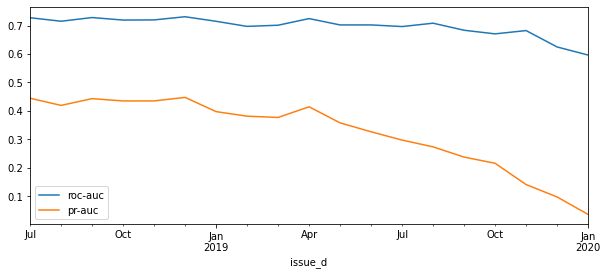

In [ ]:
y_pred_test = lgbm.predict_proba(X_test, batch_size=1024)[:, 1].flatten()
df_test= pd.DataFrame(data=issue_d_test)
df_test['y_test'] = y_test
df_test['y_pred_test'] = y_pred_test.flatten()
df_test

df_test_aucs = df_test.groupby('issue_d').apply(lambda s: pd.Series({ 
    "charged_off_rate": s['y_test'].mean(),
    "roc-auc": my_roc_auc_score(s['y_test'], s['y_pred_test']), 
    "pr-auc": sklearn.metrics.average_precision_score(s['y_test'], s['y_pred_test']), 
}))
# df_test_aucs
df_test_aucs[['roc-auc', 'pr-auc']].plot(figsize=(10, 4))

##### Feature Importance

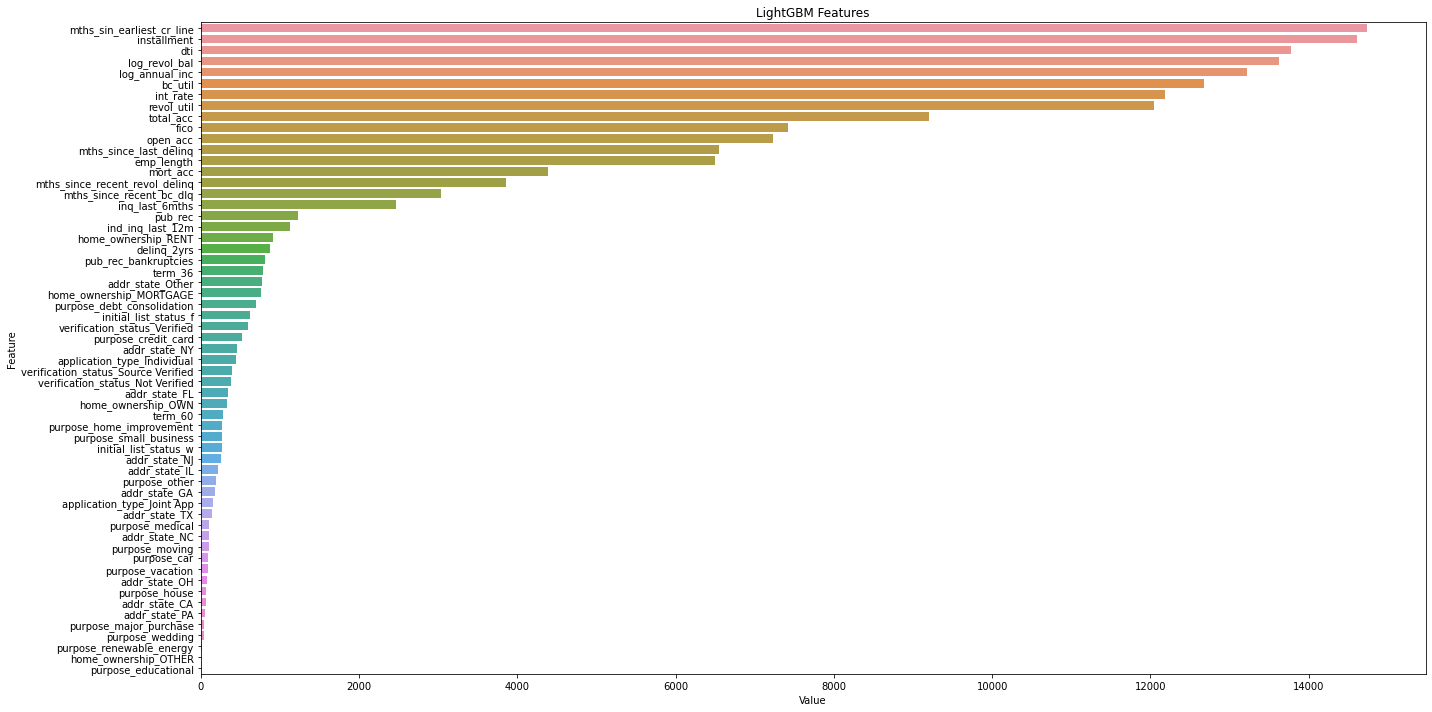

In [ ]:
feature_imp = pd.DataFrame(sorted(zip(lgbm.feature_importances_, feature_names)), columns=['Value','Feature'])

plt.figure(figsize=(20, 10))
sns.barplot(x="Value", y="Feature", data=feature_imp.sort_values(by="Value", ascending=False))
plt.title('LightGBM Features')
plt.tight_layout()
plt.show()

##### Shap values

Explain feature importance for an instance in train data

In [ ]:
selected_indexes = np.random.choice(X_train.shape[0], 1000, replace=False)
X_sample = X_train[selected_indexes, :]
y_sample = y_train[selected_indexes]

shap_values_with_bias = lgbm.predict(X_sample, pred_contrib=True) ## the last element of each row is the bias term
y_pred_logit = lgbm.predict(X_sample, raw_score=True)
y_pred_prob = lgbm.predict_proba(X_sample)[:, 1]
explainer_expected_value = shap_values_with_bias[0, -1]

assert np.allclose(y_pred_logit, shap_values_with_bias.sum(axis=1), rtol=1e-02) ## sum of shap values equal to y_pred_logit
assert np.allclose(tf.math.sigmoid(y_pred_logit), y_pred_prob, rtol=1e-02) ## sigmoid(y_pred_logit)==y_pred_probability

In [ ]:
## example: label=0 (paid_off)

# print the JS visualization code to the notebook
shap.initjs()

idx = np.argwhere(1-y_sample)[0][0]
print('true label: ', y_sample[idx])
print('predicted charged-off probability', y_pred_prob[idx])
shap.force_plot(explainer_expected_value, 
                shap_values_with_bias[idx,:-1], 
                scaler.inverse_transform(np.atleast_2d(X_sample[idx,:])),
                feature_names=feature_names)

true label:  0
predicted charged-off probability 0.015879798763099036


In [ ]:
## example: label=1 (charged_off)

# print the JS visualization code to the notebook
shap.initjs()
idx = np.argwhere(y_sample)[0][0]
print('true label: ', y_sample[idx])
print('predicted charged-off probability', y_pred_prob[idx])
shap.force_plot(explainer_expected_value, 
                shap_values_with_bias[idx,:-1], 
                scaler.inverse_transform(np.atleast_2d(X_sample[idx,:])),
                feature_names=feature_names)

true label:  1
predicted charged-off probability 0.0954736431595814


Explain feature importance for an instance in test data

In [ ]:
selected_indexes = np.random.choice(X_test.shape[0], 1000, replace=False)
X_sample = X_test[selected_indexes, :]
y_sample = y_test[selected_indexes]

shap_values_with_bias = lgbm.predict(X_sample, pred_contrib=True) ## the last element of each row is the bias term
y_pred_logit = lgbm.predict(X_sample, raw_score=True)
y_pred_prob = lgbm.predict_proba(X_sample)[:, 1]
explainer_expected_value = shap_values_with_bias[0, -1]

assert np.allclose(y_pred_logit, shap_values_with_bias.sum(axis=1), rtol=1e-02) ## sum of shap values equal to y_pred_logit
assert np.allclose(tf.math.sigmoid(y_pred_logit), y_pred_prob, rtol=1e-02) ## sigmoid(y_pred_logit)==y_pred_probability

In [ ]:
## example: label=0 (paid_off)

# print the JS visualization code to the notebook
shap.initjs()

idx = np.argwhere(1-y_sample)[0][0]
print('true label: ', y_sample[idx])
print('predicted charged-off probability', y_pred_prob[idx])
shap.force_plot(explainer_expected_value, 
                shap_values_with_bias[idx,:-1], 
                scaler.inverse_transform(np.atleast_2d(X_sample[idx,:])),
                feature_names=feature_names)

true label:  0
predicted charged-off probability 0.19568005420558257


In [ ]:
## example: label=1 (charged_off)

# print the JS visualization code to the notebook
shap.initjs()
idx = np.argwhere(y_sample)[1][0]
if y_sample[idx]==1.0:
    pred_class = 'charged_off'
else:
    pred_class = 'paid_off'
print('true label: ', pred_class)
print('predicted charged-off probability', y_pred_prob[idx])
shap.force_plot(explainer_expected_value,  
                shap_values_with_bias[idx,:-1], 
                scaler.inverse_transform(np.atleast_2d(X_sample[idx,:])),
                feature_names=feature_names)

true label:  charged_off
predicted charged-off probability 0.36191716158900955


Explain feature importance for large amount of instances

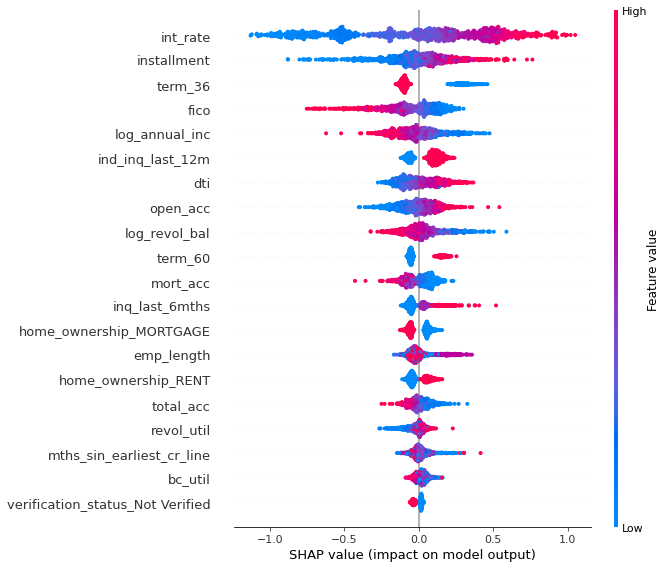

In [ ]:
shap.summary_plot(shap_values_with_bias[:,:-1], X_sample, feature_names=feature_names)

Dependence plot

In [ ]:
feature_names_index_map = {name: idx for idx, name in enumerate(feature_names)}
# feature_names_index_map

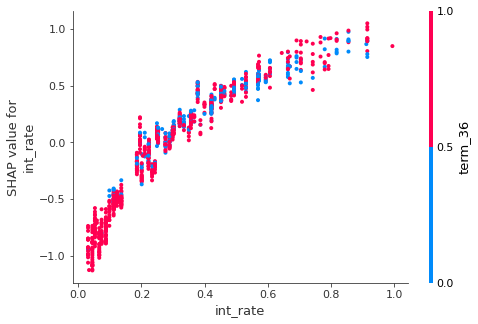

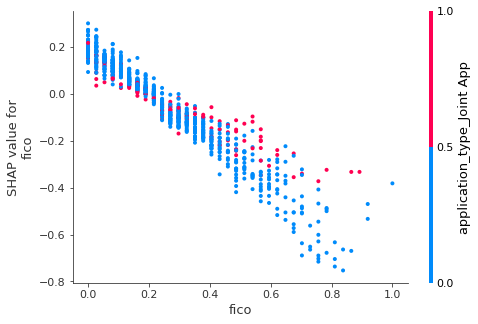

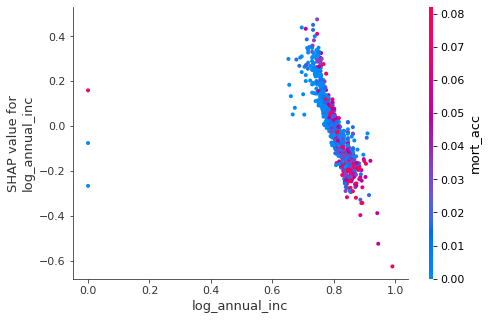

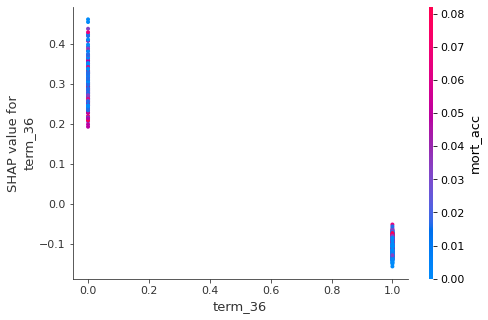

In [ ]:
for col_name in ['int_rate', 'fico', 'log_annual_inc', 'term_36']:
    shap.dependence_plot(feature_names_index_map[col_name], 
                        shap_values=shap_values_with_bias[:, :-1], 
                        features=X_sample,
                        feature_names=feature_names)

SHAP Interaction Values
https://shap.readthedocs.io/en/latest/example_notebooks/tabular_examples/tree_based_models/NHANES%20I%20Survival%20Model.html?highlight=dependence_plot#Compute-SHAP-Interaction-Values

In [ ]:
# takes a couple minutes since SHAP interaction values take a factor of 2 * # features
# more time than SHAP values to compute, since this is just an example we only explain
# the first 100 people in order to run quicker

selected_indexes = np.random.choice(X_train.shape[0], 100, replace=False)
X_sample = X_train[selected_indexes, :]
y_sample = y_train[selected_indexes]

explainer = shap.TreeExplainer(lgbm)
shap_values = explainer.shap_values(X_sample)

shap_interaction_values = shap.TreeExplainer(lgbm).shap_interaction_values(X_sample)

In [ ]:
shap_interaction_values.shape

(100, 59, 59)

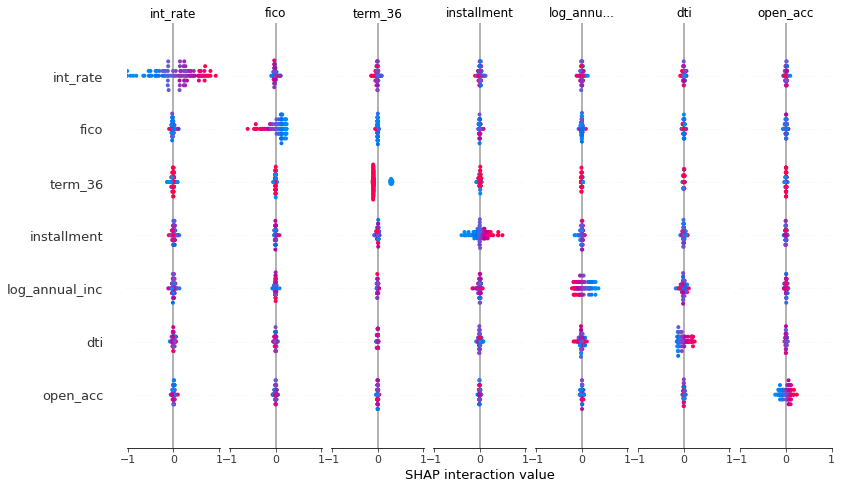

In [ ]:
shap.summary_plot(shap_interaction_values, 
                  X_sample, 
                  feature_names=np.array(feature_names))
# feature_names

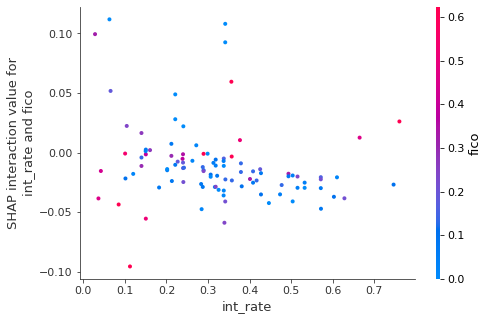

In [ ]:
shap.dependence_plot((feature_names_index_map['int_rate'], 
                      feature_names_index_map['fico']), 
                     shap_values=shap_interaction_values, 
                     features=X_sample,
                     feature_names=np.array(feature_names))

#### Neural Network

##### Model Training

In [ ]:
timestr = time.strftime("%Y%m%d_%H%M%S")
saved_bay_opt_res_name = trained_model_folder_path+'bay_opt_nn_model_res_'+timestr+'.csv'
saved_model_name = trained_model_folder_path+'bay_opt_nn_model_'+timestr+'.h5'

saved_model_name

'/content/drive/MyDrive/Colab Notebooks/Kaggle/LendingClub/trained_models/bay_opt_nn_model_20210725_053423.h5'

In [ ]:
def getNNmodel(input_dim, dropout_rate, learning_rate):
    model = Sequential([
            Dense(1024, activation="relu", input_shape=input_dim),
            Dropout(dropout_rate), 
            Dense(512, activation="selu"), 
            Dropout(dropout_rate), 
            Dense(256, activation="selu"), 
            Dropout(dropout_rate), 
            Dense(256, activation="selu"), 
            Dropout(dropout_rate), 
            Dense(128, activation="selu"), 
            Dropout(dropout_rate), 
            Dense(128, activation="selu"), 
            Dropout(dropout_rate), 
            Dense(64, activation="selu"), 
            Dropout(dropout_rate), 
            Dense(64, activation="selu"), 
            Dropout(dropout_rate), 
            Dense(64, activation="selu"), 
            Dropout(dropout_rate), 
            Dense(32, activation="selu"), 
            Dense(32, activation="selu"), 
            Dense(1)
    ])

    metrics = [
            keras.metrics.AUC(from_logits=True, 
                              name='prc', 
                              curve='PR'), # precision-recall curve
    ]
    # Compile model
    model.compile(
                  loss=keras.losses.BinaryCrossentropy(from_logits=True), 
                  optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate), 
                  metrics=metrics)
    return model

def bayes_parameter_opt_nn_model(X_tr, y_tr, 
                                 X_val, y_val,
                                 init_round=15,
                                 opt_round=25):
    input_dim = X_tr.shape[1:]
    EPOCHS = 500
    BATCH_SIZE = 512
    
    # https://www.tensorflow.org/tutorials/structured_data/imbalanced_data#calculate_class_weights
    ## Scaling by total/2 helps keep the loss to a similar magnitude.
    # The sum of the weights of all examples stays the same.
    counts = np.bincount(y_tr)
    # print(
    #     "Number of positive samples in training data: {} ({:.2f}% of total)".format(
    #         counts[1], 100 * float(counts[1]) / len(y_tr)
    #     ))   
    total = counts[0]+counts[1]
    weight_for_0 = 1.0 / counts[0] * (total / 2.0)
    weight_for_1 = 1.0 / counts[1] * (total / 2.0)
    class_weight = {0: weight_for_0, 1: weight_for_1}

    def nn_model_eval(dropout_rate, exp_learning_rate):
        """
        Neural network cross validation.
        This function will instantiate a neural network classifier with parameters dropout_rate and learning_rate. 
        Combined with data and targets this will in turn be used to perform
        cross validation. The result of cross validation is returned.
        Our goal is to find combinations of dropout_rate and learning_rate. that maximizes the pr_auc (average_precision)
        metric.
        """
        learning_rate = 10 ** exp_learning_rate
        model = getNNmodel(input_dim, dropout_rate, learning_rate)
        early_stopping = tf.keras.callbacks.EarlyStopping(
                                                monitor='val_prc', 
                                                verbose=0,
                                                patience=10,
                                                mode='max')
        
        history = model.fit(X_tr, y_tr,
                            batch_size=BATCH_SIZE,
                            epochs=EPOCHS,
                            callbacks=[early_stopping],
                            validation_data=(X_val, y_val),
                            # The class weights go here
                            class_weight=class_weight,
                            verbose=0) 
        
        return max(history.history['val_prc'])
    

    # range
    nn_modelBO = BayesianOptimization(nn_model_eval, {
                                                    'dropout_rate': (0, 0.4), 
                                                    'exp_learning_rate': (-4, -2)
                                                    }, 
                                        random_state=0)
    # optimize
    nn_modelBO.maximize(init_points=init_round, n_iter=opt_round)
    
    return nn_modelBO


In [ ]:
# %%time
# print('target: pr-auc')
# nn_modelBO = bayes_parameter_opt_nn_model(X_train, y_train, 
#                                      X_test, y_test,
#                                      init_round=10,
#                                      opt_round=15)

# nn_modelBO_res = pd.DataFrame(nn_modelBO.res)
# nn_modelBO_res.to_csv(saved_bay_opt_res_name)
# saved_bay_opt_res_name

In [ ]:
# nn_modelBO_res = pd.read_csv(saved_bay_opt_res_name)
nn_modelBO_res = pd.read_csv(trained_model_folder_path+'bay_opt_nn_model_res_20210721_054514.csv')
best_params = nn_modelBO_res.sort_values(by='target', ascending=False).reset_index().loc[0, 'params']
best_params = best_params.replace("'", '"')
best_params = json.loads(best_params)
best_params = dict(best_params)

learning_rate = 10 ** best_params['exp_learning_rate']
best_params['learning_rate'] = learning_rate
del best_params['exp_learning_rate']

## fixed parameters
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_prc', 
                                                  verbose=1,
                                                  patience=10,
                                                  mode='max')
input_dim = X_train.shape[1:]
EPOCHS = 500
BATCH_SIZE = 512

counts = np.bincount(y_train)
# print(
#     "Number of positive samples in training data: {} ({:.2f}% of total)".format(
#         counts[1], 100 * float(counts[1]) / len(y_tr)
#     ))   
total = counts[0]+counts[1]
weight_for_0 = 1.0 / counts[0] * (total / 2.0)
weight_for_1 = 1.0 / counts[1] * (total / 2.0)
class_weight = {0: weight_for_0, 1: weight_for_1}

best_params

{'dropout_rate': 0.19939132582196092, 'learning_rate': 0.0003044552938305069}

In [ ]:
# nn_model = getNNmodel(input_dim, **best_params)
# # nn_model.summary()

# history = nn_model.fit(X_train, y_train,
#                         batch_size=BATCH_SIZE,
#                         epochs=EPOCHS,
#                         callbacks=[early_stopping],
#                         validation_data=(X_test, y_test),
#                         # The class weights go here
#                         class_weight=class_weight,
#                         verbose=1) 

# nn_model.save(saved_model_name)

In [ ]:
# nn_model = keras.models.load_model(saved_model_name)
nn_model = keras.models.load_model(trained_model_folder_path+'bay_opt_nn_model_20210721_054514.h5')

##### Evaluation

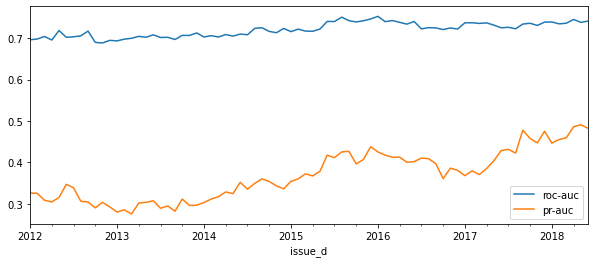

In [ ]:
y_pred_logits = nn_model.predict(X_train, batch_size=1024)
y_pred_proba = tf.math.sigmoid(y_pred_logits).numpy().flatten()
df_train= pd.DataFrame(data=issue_d_train)
df_train['y_train'] = y_train
df_train['y_pred_train'] = y_pred_proba

df_train_aucs = df_train.groupby('issue_d').apply(lambda s: pd.Series({ 
    "charged_off_rate": s['y_train'].mean(),
    "roc-auc": my_roc_auc_score(s['y_train'], s['y_pred_train']), 
    "pr-auc": sklearn.metrics.average_precision_score(s['y_train'], s['y_pred_train']), 
}))
df_train_aucs[['roc-auc', 'pr-auc']].plot(figsize=(10, 4))

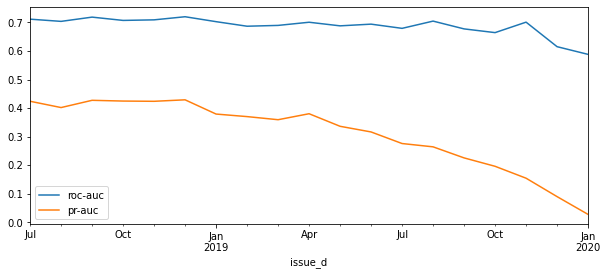

In [ ]:
y_pred_logits = nn_model.predict(X_test, batch_size=1024)
y_pred_proba = tf.math.sigmoid(y_pred_logits).numpy().flatten()
df_test= pd.DataFrame(data=issue_d_test)
df_test['y_test'] = y_test
df_test['y_pred_test'] = y_pred_proba
df_test

df_test_aucs = df_test.groupby('issue_d').apply(lambda s: pd.Series({ 
    "charged_off_rate": s['y_test'].mean(),
    "roc-auc": my_roc_auc_score(s['y_test'], s['y_pred_test']), 
    "pr-auc": sklearn.metrics.average_precision_score(s['y_test'], s['y_pred_test']), 
}))
# df_test_aucs
df_test_aucs[['roc-auc', 'pr-auc']].plot(figsize=(10, 4))

##### Shap Values

In [ ]:
def f(X):
    return nn_model.predict(X).flatten()

Explain feature importance for an instance in train data

In [ ]:
selected_indexes = np.random.choice(X_train.shape[0], 100, replace=False)
X_sample = X_train[selected_indexes, :]
y_sample = y_train[selected_indexes]
y_pred_logits = nn_model.predict(X_sample).flatten()
y_pred_prob = tf.math.sigmoid(y_pred_logits).numpy()

explainer = shap.KernelExplainer(f, X_sample)

In [ ]:
# print the JS visualization code to the notebook
shap.initjs()

idx = np.argwhere(1-y_sample)[0][0]
if y_sample[idx]==1.0:
    pred_class = 'charged_off'
else:
    pred_class = 'paid_off'
print('true label:', y_sample[idx], pred_class)
print('predicted charged-off probability', y_pred_prob[idx])
shap_values = explainer.shap_values(X_sample[idx, :], nsamples=500)
shap.force_plot(explainer.expected_value, 
                shap_values, 
                scaler.inverse_transform(np.atleast_2d(X_sample[idx,:])), 
                feature_names=feature_names)

true label: 0 paid_off
predicted charged-off probability 0.44395393


In [ ]:
# print the JS visualization code to the notebook
shap.initjs()

idx = np.argwhere(y_sample)[0][0]
if y_sample[idx]==1.0:
    pred_class = 'charged_off'
else:
    pred_class = 'paid_off'
print('true label:', y_sample[idx], pred_class)
print('predicted charged-off probability', y_pred_prob[idx])
shap_values = explainer.shap_values(X_sample[idx, :], nsamples=500)
shap.force_plot(explainer.expected_value, 
                shap_values, 
                scaler.inverse_transform(np.atleast_2d(X_sample[idx,:])), 
                feature_names=feature_names)

true label: 1 charged_off
predicted charged-off probability 0.5221054


Explain feature importance for an instance in train data

In [ ]:
selected_indexes = np.random.choice(X_test.shape[0], 100, replace=False)
X_sample = X_test[selected_indexes, :]
y_sample = y_test[selected_indexes]
y_pred_logits = nn_model.predict(X_sample).flatten()
y_pred_prob = tf.math.sigmoid(y_pred_logits).numpy()

explainer = shap.KernelExplainer(f, X_sample)

In [ ]:
# print the JS visualization code to the notebook
shap.initjs()

idx = np.argwhere(1-y_sample)[0][0]
if y_sample[idx]==1.0:
    pred_class = 'charged_off'
else:
    pred_class = 'paid_off'
print('true label:', y_sample[idx], pred_class)
print('predicted charged-off probability', y_pred_prob[idx])
shap_values = explainer.shap_values(X_sample[idx, :], nsamples=500)
shap.force_plot(explainer.expected_value, 
                shap_values, 
                scaler.inverse_transform(np.atleast_2d(X_sample[idx,:])), 
                feature_names=feature_names)

true label: 0 paid_off
predicted charged-off probability 0.5792806


In [ ]:
# print the JS visualization code to the notebook
shap.initjs()

idx = np.argwhere(y_sample)[0][0]
if y_sample[idx]==1.0:
    pred_class = 'charged_off'
else:
    pred_class = 'paid_off'
print('true label:', y_sample[idx], pred_class)
print('predicted charged-off probability', y_pred_prob[idx])
shap_values = explainer.shap_values(X_sample[idx, :], nsamples=500)
shap.force_plot(explainer.expected_value, 
                shap_values, 
                scaler.inverse_transform(np.atleast_2d(X_sample[idx,:])), 
                feature_names=feature_names)

true label: 1 charged_off
predicted charged-off probability 0.36822122


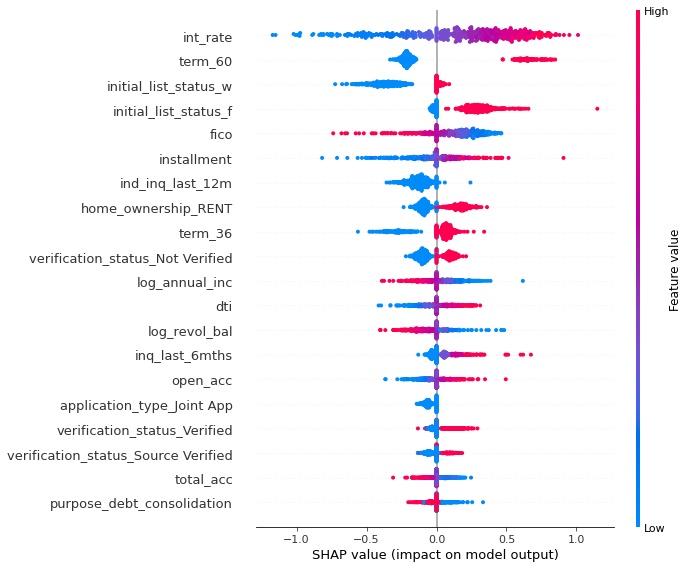

In [ ]:
selected_indexes = np.random.choice(X_test.shape[0], 500, replace=False)
X_sample = X_train[selected_indexes, :]
y_sample = y_train[selected_indexes]

shap_values = explainer.shap_values(X_sample, nsamples=500)
shap.summary_plot(shap_values, X_sample, feature_names=feature_names)

####  GAM

##### Model Training

In [ ]:
timestr = time.strftime("%Y%m%d_%H%M%S")
# saved_bay_opt_res_name = trained_model_folder_path+'bay_opt_logreg_res_'+timestr+'.csv'
saved_model_name = trained_model_folder_path+'GAM_'+timestr+'.pkl'

saved_model_name

'/content/drive/MyDrive/Colab Notebooks/Kaggle/LendingClub/trained_models/GAM_20210725_054852.pkl'

In [ ]:
## Label encoding across multiple columns in scikit-learn
## https://stackoverflow.com/questions/24458645/label-encoding-across-multiple-columns-in-scikit-learn

d = defaultdict(LabelEncoder)
# Encoding the variable
# fit = data_sample.apply(lambda x: d[x.name].fit_transform(x))
data_copy[cat_cols] = data_copy[cat_cols].apply(lambda x: d[x.name].fit_transform(x))

# # Inverse the encoded
# data_copy[cat_cols] = data_copy[cat_cols].apply(lambda x: d[x.name].inverse_transform(x))

# # Using the dictionary to label future data
# data_copy.apply(lambda x: d[x.name].transform(x))

# data_copy.head()

In [ ]:
# time_begin = pd.to_datetime('2012-01-01')
# time_split = pd.to_datetime('2018-06-01')
# time_end = pd.to_datetime('2020-01-01')

data_train_gam = data_copy.loc[data_copy['issue_d']>=time_begin, :]
data_train_gam = data_train_gam.loc[data_train_gam['issue_d']<=time_split, :]
data_test_gam = data_copy.loc[(data_copy['issue_d']<=time_end), :]
data_test_gam = data_test_gam.loc[data_test_gam['issue_d']>time_split, :]

In [ ]:
data_train_gam.shape, data_test_gam.shape

((1654644, 30), (163259, 30))

In [ ]:
X_train_gam = data_train_gam.drop(columns=['charged_off', 'issue_d']).values
y_train_gam = data_train_gam['charged_off'].values
issue_d_train_gam = data_train_gam['issue_d']
feature_names_gam = data_train_gam.drop(columns=['charged_off', 'issue_d']).columns.to_list()
X_train_gam.shape, y_train_gam.shape

((1654644, 28), (1654644,))

In [ ]:
X_test_gam = data_test_gam.drop(columns=['charged_off', 'issue_d']).values
y_test_gam = data_test_gam['charged_off'].values
issue_d_test_gam= data_test_gam['issue_d']
X_test_gam.shape, y_test_gam.shape

((163259, 28), (163259,))

In [ ]:
# data_train_gam.head()

In [ ]:
## create terms for GAM
terms = TermList() ## https://github.com/dswah/pyGAM/issues/258

for idx, col in enumerate(data_train_gam.drop(columns=['charged_off', 'issue_d']).columns.to_list()):
    if col.startswith(tuple(cat_cols)) or col.startswith('ind_'):
        # print(idx, col)
        terms += FactorTerm(idx, coding='dummy')
        # terms += f(idx)
    else:
        # print(idx, col)
        terms += s(idx)

print('formula for GAM')
print(terms)
for col, term in zip(data_train_gam.drop(columns=['charged_off', 'issue_d']).columns.to_list(), terms):
    print(col, ':', term)

formula for GAM
f(0) + f(1) + s(2) + s(3) + s(4) + f(5) + s(6) + s(7) + s(8) + s(9) + s(10) + s(11) + f(12) + s(13) + f(14) + s(15) + f(16) + s(17) + s(18) + f(19) + s(20) + s(21) + s(22) + s(23) + s(24) + s(25) + s(26) + f(27)
addr_state : factor_term
application_type : factor_term
dti : spline_term
emp_length : spline_term
fico : spline_term
home_ownership : factor_term
installment : spline_term
int_rate : spline_term
mort_acc : spline_term
open_acc : spline_term
pub_rec : spline_term
pub_rec_bankruptcies : spline_term
purpose : factor_term
revol_util : spline_term
term : factor_term
total_acc : spline_term
verification_status : factor_term
bc_util : spline_term
delinq_2yrs : spline_term
initial_list_status : factor_term
inq_last_6mths : spline_term
mths_since_last_delinq : spline_term
mths_since_recent_bc_dlq : spline_term
mths_since_recent_revol_delinq : spline_term
log_annual_inc : spline_term
mths_sin_earliest_cr_line : spline_term
log_revol_bal : spline_term
ind_inq_last_12m : f

In [ ]:
rus = RandomUnderSampler(random_state=0)
X_resampled, y_resampled = rus.fit_resample(X_train_gam, y_train_gam)
X_resampled.shape, y_resampled.shape

((646540, 28), (646540,))

In [ ]:
# %%time
# gam = LogisticGAM(terms) 
# param_grids = {
#     # 'n_splines': np.arange(10, 30, 5), 
#     # 'spline_order': np.arange(1, 3),
#     # 'lam': np.arange(0.4, 1.0, 0.2),  ## lam = np.logspace(-1, 2, 5)
#     # 'n_splines': np.arange(15, 30, 5), 
#     'n_splines': np.arange(15, 25, 5),
#     'lam': np.logspace(-1, 1, 3),
#     'spline_order': np.arange(2, 4),
# }
# gridsearch_scores = gam.gridsearch(X_resampled, y_resampled, 
#                                    return_scores=True, 
#                                    **param_grids)
# joblib.dump(gam, saved_model_name)

In [ ]:
# gam = joblib.load(saved_model_name)
saved_model_name = trained_model_folder_path+'GAM_20210722_164957.pkl'
gam = joblib.load(saved_model_name)

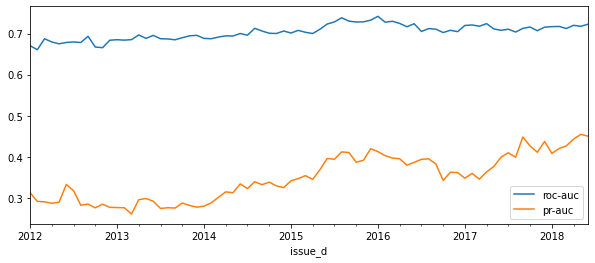

In [ ]:
y_pred_train = gam.predict_proba(X_train_gam)
df_train= pd.DataFrame(data=issue_d_train)
df_train['y_train'] = y_train
df_train['y_pred_train'] = y_pred_train.flatten()

df_train_aucs = df_train.groupby('issue_d').apply(lambda s: pd.Series({ 
    "charged_off_rate": s['y_train'].mean(),
    "roc-auc": my_roc_auc_score(s['y_train'], s['y_pred_train']), 
    "pr-auc": sklearn.metrics.average_precision_score(s['y_train'], s['y_pred_train']), 
}))
df_train_aucs[['roc-auc', 'pr-auc']].plot(figsize=(10, 4))

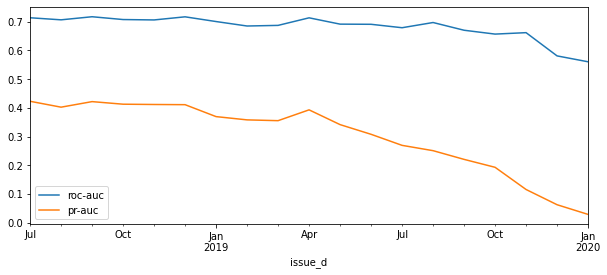

In [ ]:
y_pred_test = gam.predict_proba(X_test_gam)
df_test= pd.DataFrame(data=issue_d_test)
df_test['y_test'] = y_test
df_test['y_pred_test'] = y_pred_test.flatten()
df_test

df_test_aucs = df_test.groupby('issue_d').apply(lambda s: pd.Series({ 
    "charged_off_rate": s['y_test'].mean(),
    "roc-auc": my_roc_auc_score(s['y_test'], s['y_pred_test']), 
    "pr-auc": sklearn.metrics.average_precision_score(s['y_test'], s['y_pred_test']), 
}))
# df_test_aucs
df_test_aucs[['roc-auc', 'pr-auc']].plot(figsize=(10, 4))

In [ ]:
# gam.summary()

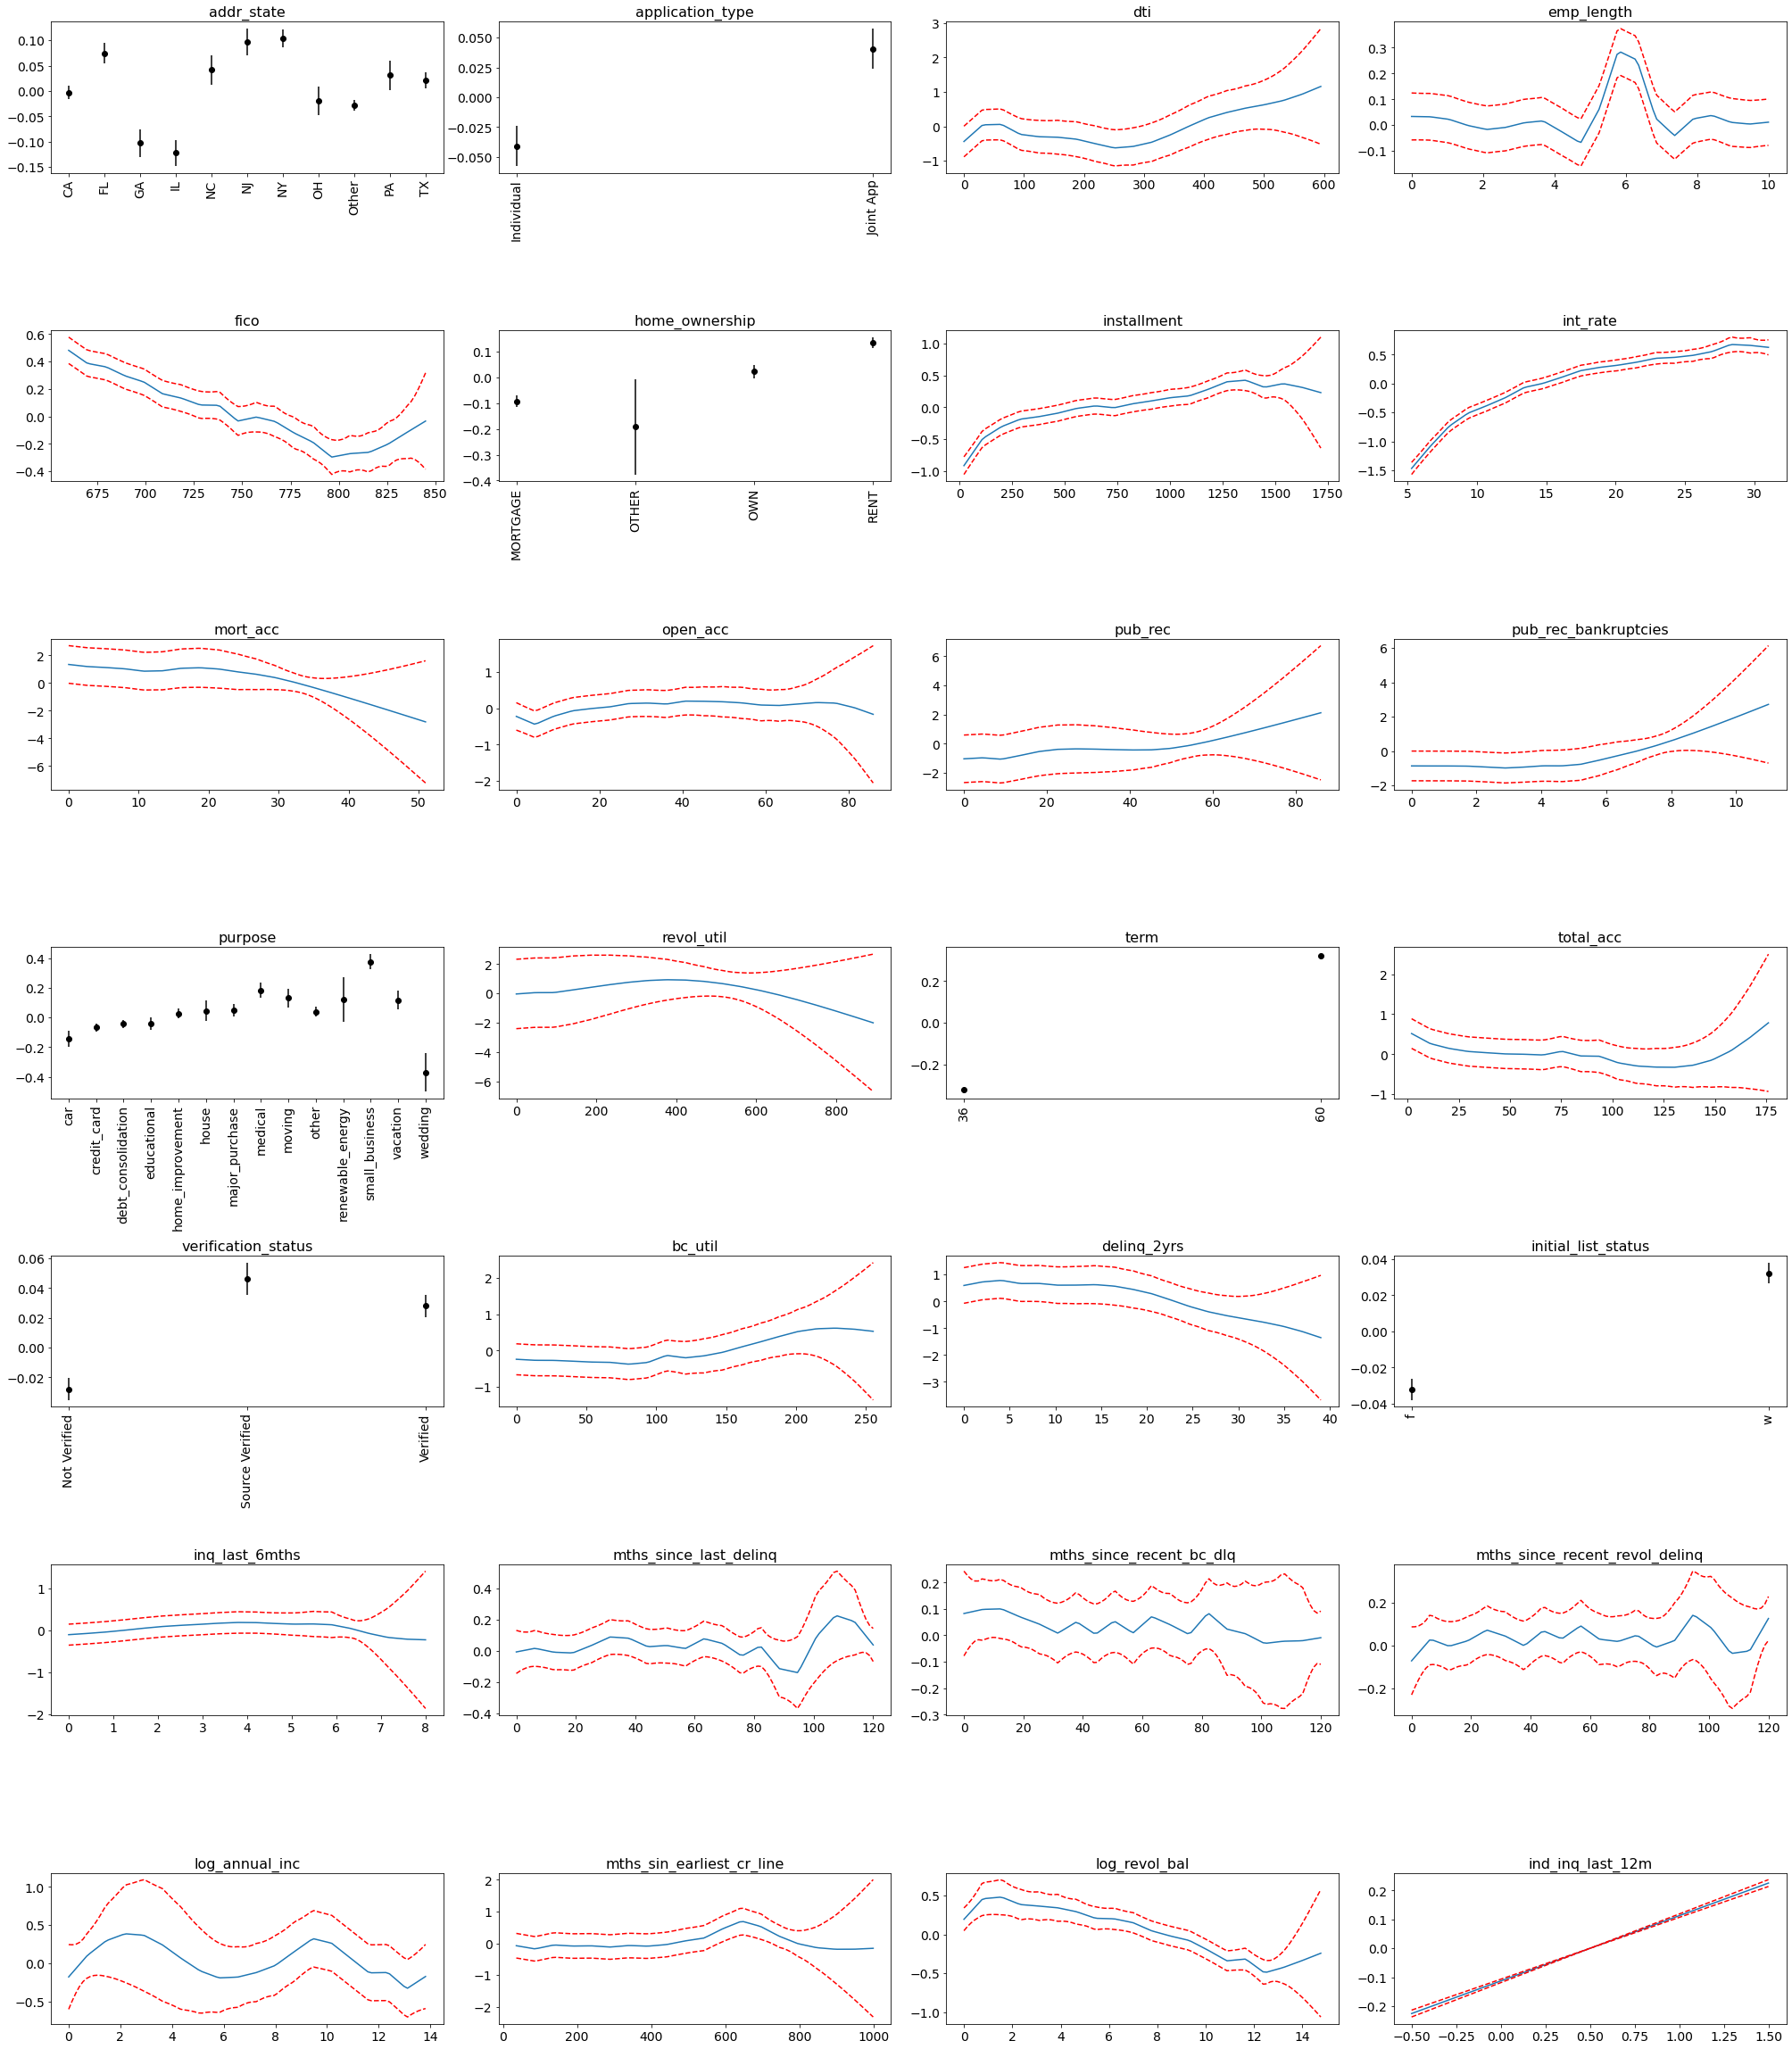

In [ ]:
ncols = 4
nrows = (X_train_gam.shape[1]+1)//ncols

fig, axs = plt.subplots(nrows, ncols, figsize=(28, 32))

cnt = 0
for idx, col in enumerate(feature_names_gam):
    row_idx, col_idx = divmod(idx, ncols)
    
    ## retrieve the label encoders 
    ## and plot partial dependence for categorical terms
    if col in cat_cols:
        le = d[col]
        le_name_mapping = dict(zip(le.transform(le.classes_), le.classes_))
        x = np.array(list(le_name_mapping.keys()))
        x_ticks = np.array(list(le_name_mapping.values()))
        XX = np.zeros((len(le_name_mapping), X_train_gam.shape[1]))
        XX[:, idx] = x
        pdep, confi = gam.partial_dependence(term=idx, X=XX, width=.95)
        ## margin of error = value-lower bound of confidence interval
        margin_err = pdep-confi[:, 0] 
        axs[row_idx][col_idx].errorbar(x=x, y=pdep, 
                                       yerr=margin_err,
                                       markersize=12,
                                       fmt='.k')
        axs[row_idx][col_idx].set_xticks(np.arange(len(x_ticks)))
        axs[row_idx][col_idx].set_xticklabels(x_ticks, Rotation=90, Fontsize=14)
                                    
    else:
        XX = gam.generate_X_grid(term=idx) 
        pdep, confi = gam.partial_dependence(term=idx, X=XX, width=.95)
        axs[row_idx][col_idx].plot(XX[:, idx], pdep)
        axs[row_idx][col_idx].plot(XX[:, idx], confi, c='r', ls='--')
        axs[row_idx][col_idx].tick_params(axis='x', labelsize=14)

    axs[row_idx][col_idx].tick_params(axis='y', labelsize=14)       
    axs[row_idx][col_idx].set_title(col, Fontsize=16)
    
plt.tight_layout()

## Model Performance Comparison

### Load models

In [ ]:
logreg = joblib.load(trained_model_folder_path+'bay_opt_logreg_model_20210720_053455.pkl')
lgbm = joblib.load(trained_model_folder_path+'bay_opt_lgb_model_20210718_211639.pkl')
xgbm = joblib.load(trained_model_folder_path+'bay_opt_xgb_model_20210724_033216.pkl')
nn_model = keras.models.load_model(trained_model_folder_path+'bay_opt_nn_model_20210721_054514.h5')
gam = joblib.load(trained_model_folder_path+'GAM_20210722_164957.pkl')

### Evaluation

#### On train data

In [ ]:
print('train data time (issue_d) range:', issue_d_train.min().date(), '-', issue_d_train.max().date())

train data time (issue_d) range: 2012-01-01 - 2018-06-01


In [ ]:
%%time
y_pred_logreg = logreg.predict_proba(X_train)[:, 1]
y_pred_lgbm = lgbm.predict_proba(X_train, batch_size=1024)[:, 1].flatten()
y_pred_xgbm = xgbm.predict(xgb.DMatrix(X_train))
## neural network outputs logits
y_pred_logits = nn_model.predict(X_train, batch_size=1024)
y_pred_nn_model = tf.math.sigmoid(y_pred_logits).numpy().flatten()
## GAM is trained using under-sampled data
## thus the performance on the complete train dataset may be worse than others
y_pred_gam = gam.predict_proba(X_train_gam)

df_train= pd.DataFrame(data=issue_d_train)
df_train['y_train'] = y_train
df_train['y_pred_logreg'] = y_pred_logreg.flatten()
df_train['y_pred_lgbm'] = y_pred_lgbm.flatten()
df_train['y_pred_xgbm'] = y_pred_xgbm.flatten()
df_train['y_pred_nn_model'] = y_pred_nn_model.flatten()
df_train['y_pred_gam'] = y_pred_gam.flatten()

df_train

CPU times: user 7min 38s, sys: 286 ms, total: 7min 38s
Wall time: 2min 20s


In [ ]:
df_train

issue_d  y_train  ...  y_pred_nn_model  y_pred_gam
186448 2012-01-01        0  ...         0.371850    0.274021
186447 2012-01-01        0  ...         0.298401    0.201364
186435 2012-01-01        0  ...         0.394711    0.395850
186446 2012-01-01        1  ...         0.365238    0.288561
186445 2012-01-01        0  ...         0.578055    0.612539
...           ...      ...  ...              ...         ...
27697  2018-06-01        0  ...         0.065096    0.152251
27695  2018-06-01        1  ...         0.670519    0.622772
27693  2018-06-01        1  ...         0.209997    0.170805
27691  2018-06-01        0  ...         0.197382    0.258982
27687  2018-06-01        0  ...         0.304365    0.253370

[1654644 rows x 7 columns]

In [ ]:
print('ROC AUC (aggregated)')
for i in range(2, df_train.shape[1]):
    col = df_train.columns.to_list()[i]
    score = roc_auc_score(df_train['y_train'], df_train[col])
    col = col.split('_')[2]
    print(col, score)

ROC AUC (aggregated)
logreg 0.7041293071280939
lgbm 0.7649982465485698
xgbm 0.7473195592893163
nn 0.7291098239100083
gam 0.7123083907685661


In [ ]:
print('PR AUC (aggregated)')
for i in range(2, df_train.shape[1]):
    col = df_train.columns.to_list()[i]
    score = average_precision_score(df_train['y_train'], df_train[col])
    col = col.split('_')[2]
    print(col, score)

PR AUC (aggregated)
logreg 0.3592292368708783
lgbm 0.460511554693173
xgbm 0.4205297248240356
nn 0.3938907726799653
gam 0.37219858553523055


In [ ]:
df_train_roc_aucs = df_train.groupby('issue_d').apply(lambda s: pd.Series({ 
    # "charged_off_rate": s['y_train'].mean(),
    "roc_auc_logreg": my_roc_auc_score(s['y_train'], s['y_pred_logreg']),
    "roc_auc_lgbm": my_roc_auc_score(s['y_train'], s['y_pred_lgbm']),
    "roc_auc_xgbm": my_roc_auc_score(s['y_train'], s['y_pred_xgbm']),
    "roc_auc_nn_model": my_roc_auc_score(s['y_train'], s['y_pred_nn_model']),
    "roc_auc_gam": my_roc_auc_score(s['y_train'], s['y_pred_gam']),
}))

df_train_pr_aucs = df_train.groupby('issue_d').apply(lambda s: pd.Series({ 
    "pr_auc_logreg": sklearn.metrics.average_precision_score(s['y_train'], s['y_pred_logreg']),
    "pr_auc_lgbm": sklearn.metrics.average_precision_score(s['y_train'], s['y_pred_lgbm']),
    "pr_auc_xgbm": sklearn.metrics.average_precision_score(s['y_train'], s['y_pred_xgbm']),
    "pr_auc_nn_model": sklearn.metrics.average_precision_score(s['y_train'], s['y_pred_nn_model']),
    "pr_auc_gam": sklearn.metrics.average_precision_score(s['y_train'], s['y_pred_gam']),
}))

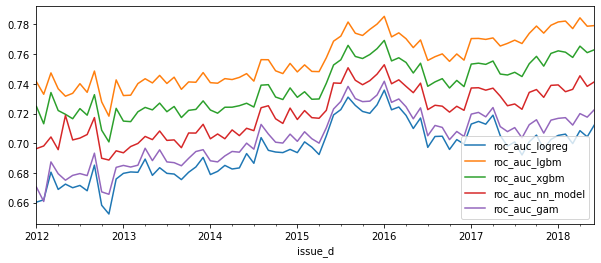

In [ ]:
df_train_roc_aucs.plot(figsize=(10, 4))

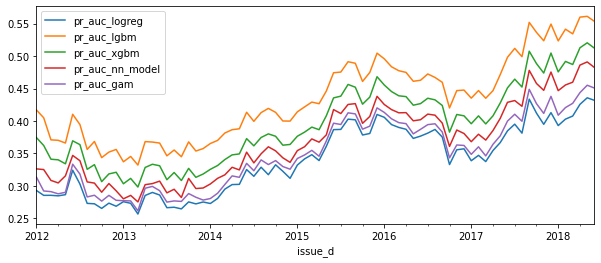

In [ ]:
df_train_pr_aucs.plot(figsize=(10, 4))

#### On test data

In [ ]:
print('test data time (issue_d) range:', issue_d_test.min().date(), '-', issue_d_test.max().date())

test data time (issue_d) range: 2018-07-01 - 2020-01-01


In [ ]:
%%time
y_pred_logreg = logreg.predict_proba(X_test)[:, 1]
y_pred_lgbm = lgbm.predict_proba(X_test, batch_size=1024)[:, 1].flatten()
y_pred_xgbm = xgbm.predict(xgb.DMatrix(X_test))
## neural network outputs logits
y_pred_logits = nn_model.predict(X_test, batch_size=1024)
y_pred_nn_model = tf.math.sigmoid(y_pred_logits).numpy().flatten()
## GAM is trained using under-sampled data
## thus the performance on the complete train dataset may be lower
y_pred_gam = gam.predict_proba(X_test_gam)

df_test= pd.DataFrame(data=issue_d_test)
df_test['y_test'] = y_test
df_test['y_pred_logreg'] = y_pred_logreg.flatten()
df_test['y_pred_lgbm'] = y_pred_lgbm.flatten()
df_test['y_pred_xgbm'] = y_pred_xgbm.flatten()
df_test['y_pred_nn_model'] = y_pred_nn_model.flatten()
df_test['y_pred_gam'] = y_pred_gam.flatten()

df_test

CPU times: user 45.4 s, sys: 36.8 ms, total: 45.4 s
Wall time: 13.7 s


In [ ]:
print('ROC AUC (aggregated)')
for i in range(2, df_test.shape[1]):
    col = df_test.columns.to_list()[i]
    score = roc_auc_score(df_test['y_test'], df_test[col])
    col = col.split('_')[2]
    print(col, score)

ROC AUC (aggregated)
logreg 0.6891887175477707
lgbm 0.7139101095526137
xgbm 0.7147894489154484
nn 0.700832504493005
gam 0.7007389558174721


In [ ]:
print('PR AUC (aggregated)')
for i in range(2, df_test.shape[1]):
    col = df_test.columns.to_list()[i]
    score = average_precision_score(df_test['y_test'], df_test[col])
    col = col.split('_')[2]
    print(col, score)

PR AUC (aggregated)
logreg 0.3491521251966679
lgbm 0.38922520754251116
xgbm 0.38875957396396993
nn 0.36937489655476585
gam 0.36386209981441353


In [ ]:
df_test_roc_aucs = df_test.groupby('issue_d').apply(lambda s: pd.Series({ 
    # "charged_off_rate": s['y_test'].mean(),
    "roc_auc_logreg": my_roc_auc_score(s['y_test'], s['y_pred_logreg']),
    "roc_auc_lgbm": my_roc_auc_score(s['y_test'], s['y_pred_lgbm']),
    "roc_auc_xgbm": my_roc_auc_score(s['y_test'], s['y_pred_xgbm']),
    "roc_auc_nn_model": my_roc_auc_score(s['y_test'], s['y_pred_nn_model']),
    "roc_auc_gam": my_roc_auc_score(s['y_test'], s['y_pred_gam']),
}))

df_test_pr_aucs = df_test.groupby('issue_d').apply(lambda s: pd.Series({ 
    "pr_auc_logreg": sklearn.metrics.average_precision_score(s['y_test'], s['y_pred_logreg']),
    "pr_auc_lgbm": sklearn.metrics.average_precision_score(s['y_test'], s['y_pred_lgbm']),
    "pr_auc_xgbm": sklearn.metrics.average_precision_score(s['y_test'], s['y_pred_xgbm']),
    "pr_auc_nn_model": sklearn.metrics.average_precision_score(s['y_test'], s['y_pred_nn_model']),
    "pr_auc_gam": sklearn.metrics.average_precision_score(s['y_test'], s['y_pred_gam']),
}))

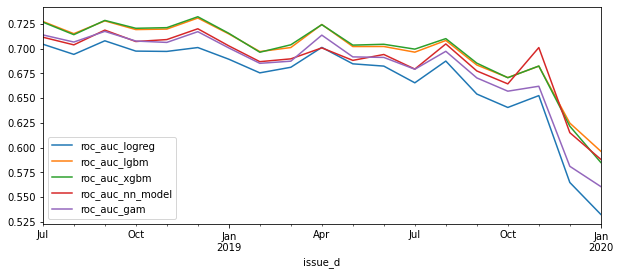

In [ ]:
df_test_roc_aucs.plot(figsize=(10, 4))

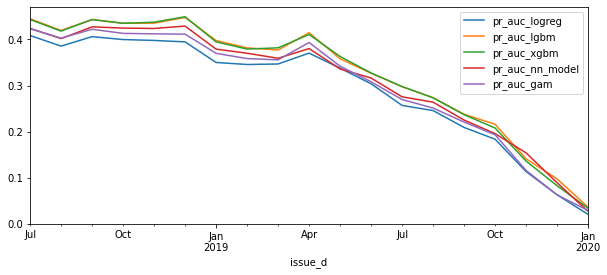

In [ ]:
df_test_pr_aucs.plot(figsize=(10, 4))

#### Evaluation Summary 

In [ ]:
# ## summary statistics
df_scores = pd.DataFrame([])
for i in range(2, df_train.shape[1]):
    name = df_train.columns.to_list()[i]
    name = name.split('_')[2]
    df_scores[name] = None

for i in range(2, df_train.shape[1]):
    pred_name = df_train.columns.to_list()[i]
    model_name = pred_name.split('_')[2]

    train_roc_auc = roc_auc_score(df_train['y_train'], df_train[pred_name])
    df_scores.loc['train_roc_auc', model_name] = np.round(train_roc_auc, 4)
    train_pr_auc = average_precision_score(df_train['y_train'], df_train[pred_name])
    df_scores.loc['train_pr_auc', model_name] = np.round(train_pr_auc, 4)

    test_roc_auc = roc_auc_score(df_test['y_test'], df_test[pred_name])
    df_scores.loc['test_roc_auc', model_name] = np.round(test_roc_auc, 4)
    test_pr_auc = average_precision_score(df_test['y_test'], df_test[pred_name])
    df_scores.loc['test_pr_auc', model_name] = np.round(test_pr_auc, 4)

df_scores.transpose()

train_roc_auc train_pr_auc test_roc_auc test_pr_auc
logreg        0.7041       0.3592       0.6892      0.3492
lgbm           0.765       0.4605       0.7139      0.3892
xgbm          0.7473       0.4205       0.7148      0.3888
nn            0.7291       0.3939       0.7008      0.3694
gam           0.7123       0.3722       0.7007      0.3639